In [1]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz


# misc
import warnings

import glob

##
import pytz
import datetime as dt
import math
import seaborn as sns

In [2]:

import biosppy
from biosppy import storage
from biosppy.signals import ecg


# misc
import warnings

#signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

## Reading, extracting and slicing data (Psychopy and Shimmer)

In [3]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals



#######---------------------------------------------------
###### ------------------Shimmer--------------------------
###----------------------------------------------------------


def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df

def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df



def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp

def get_list_timestamp_interest(starting_timestamp, list_offset_mins):
    
    starting_timestamp_list=[]
    
    for offset_min in list_offset_mins:
        starting_timestamp_list.append(starting_timestamp)
        timestamp_offset = get_offset_timestamp(starting_timestamp, offset_min)
        starting_timestamp = timestamp_offset  
     
    
    #starting_timestamp_list = sorted(starting_timestamp_list, key = lambda x:float(x))
    return starting_timestamp_list
        
        

def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def from_str_to_float(str_list):
    
    float_array =[float(val) for val in str_list]
    
    return float_array

def col_from_str_float (df, col_name):
    
    str_list = df[col_name].values
    
    float_array =[float(val) for val in str_list]
    
    df[col_name] = float_array
    
    return df

## Plotting data

In [4]:
def plot_mean_std(mean_list, std_list, label_list, title_figure, y_label_fig):
    x_pos = np.arange(len(label_list))
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_list, yerr=std_list, align='center', alpha=0.5, capsize=10 )
    ax.set_ylabel(y_label_fig)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(label_list, rotation=45, ha='right', rotation_mode='anchor')
    #title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD"
    ax.set_title(title_figure)
    ax.yaxis.grid(True)
    #plt.ylim(0, 1) 
    plt.tight_layout()
    plt.show()
    return fig

## HRV: Time Domain Analysis

In [5]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity



def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, int(np.median(peak_group)))
        
        
    #output = int(output)
    return output



def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))
        
 



def filter_rr(rr, throshold_high=0.5, threshold_low=0.5):
    
    #outlier_high = np.mean(rr) + throshold_high * np.std(rr)
    outlier_high =1500
    #print(outlier_high)
    
    rr_clean_high = [rr_val for rr_val in rr if rr_val <  outlier_high]
    
    rr_clean_high = np.array(rr_clean_high)
    
    #outlier_low = np.mean(rr_clean_high) - threshold_low*np.std(rr_clean_high)
    outlier_low = 400
    #print(outlier_low)
    
    rr_clean_high_low = [rr_val for rr_val in rr_clean_high if rr_val >  outlier_low]
    
    rr_clean_high_low= np.array(rr_clean_high_low)
    
    return rr_clean_high_low


        
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    #results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

## HRV: Frequency Domain

In [6]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

## Fetching info and calculate mean and standard deviation 

In [7]:
def get_mean_std_event_list(psychopy_df, shimmer_df_selected, event_interest_list_new, offset_min_list_new, timestamp_sensor_col_name, data_col_name):

    mean_cumm_list = []
    std_cumm_list  = []
    event_interets_plot = []
    
    all_rr_one_list = []
    all_rr_sublist = []
    
    
    
    
    


    ##---outer loop to handle muultiple offsets from the selected events 
    for ind, event_selected in enumerate(event_interest_list_new):

        offset_list_selected_event = offset_min_list_new[ind]

        #print(event_selected)

        current_event_timestamp = get_nonNan_list_psychopy(psychopy_df, event_selected)[0]

        offset_min_list_selected = offset_min_list_new[ind]
        
        acc_min_print = 0

        for offset_min in offset_min_list_selected:
            
            offset_min_print = offset_min + acc_min_print
            
            acc_min_print = offset_min_print

            event_plot = event_selected +" "+ str(offset_min_print) + " min"
            
            print(event_plot)
            
            event_interets_plot.append(event_plot)

            timestamp_offset = get_offset_timestamp(current_event_timestamp, offset_min)

            start_end_time_list = [current_event_timestamp, timestamp_offset]

            timestamp_start_slice = min(start_end_time_list)

            timestamp_end_slice = max(start_end_time_list)

            sensor_df_ii=slice_df_wrt_timestamps(shimmer_df_selected, timestamp_start_slice, timestamp_end_slice, timestamp_sensor_col_name)
            
            #print(sensor_df_ii)
            
            ecg_df_ii=sensor_df_ii.reset_index(drop=True)
            
            
            #cond_slice_main = (ecg_df_ii[timestamp_sensor_col_name] >= timestamp_start_slice) & (ecg_df_ii[timestamp_sensor_col_name] < timestamp_end_slice)
            
            ecg_slice = ecg_df_ii.heartrate
            
            out = ecg.ecg(signal=ecg_slice, sampling_rate=256, show=False,interactive=False)
            
            r_peaks = out["rpeaks"]
            
            r_peaks_sec = r_peaks*1/256
            r_peaks_msec = r_peaks_sec*1000

            r_peaks_diff=np.diff(r_peaks_msec)
            
            
            print(timedomain(r_peaks_diff))
            

            
            #peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
            #grouped_peaks = group_peaks(peaks)
            #grouped_peak_msec =group_peaks_from_ind_to_msec(grouped_peaks, 256)
            #rr = np.diff(grouped_peak_msec)
            #print(timedomain(rr))
            
            
            #cleaned_rr = filter_rr(r_peaks_diff)
            cleaned_rr=r_peaks_diff
            mean_rr = np.mean(cleaned_rr) 
            std_rr = np.std(cleaned_rr)
            
            mean_cumm_list.append(mean_rr)
            std_cumm_list.append(std_rr)
            
            all_rr_one_list.extend(cleaned_rr)
            all_rr_sublist.append(cleaned_rr)
            
            
            #event_interets_plot
            
            #print(np.mean(cleaned_rr))
            #print(np.std(cleaned_rr))
            


            current_event_timestamp = timestamp_offset
            
            
            
    return mean_cumm_list, std_cumm_list, event_interets_plot, all_rr_one_list, all_rr_sublist

## Paths and files

In [14]:
#data_dir_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3"
data_dir_path = "D:/Datasets/data_sony_digiRelax/study"
sub_dirs=next(os.walk(data_dir_path))[1]

In [15]:
sub_dirs

['VP004_081123',
 'VP005_081123',
 'VP006_091123',
 'VP007_091123',
 'VP008_101123',
 'VP009_101123',
 'VP010_131123',
 'VP011_131123',
 'VP012_141123',
 'VP013_151123',
 'VP014_151123',
 'VP015_161123',
 'VP016_161123',
 'VP017_171123',
 'VP018_201123',
 'VP019_201123',
 'VP020_221123',
 'VP021_221123',
 'VP022_231123',
 'VP023_231123',
 'VP024_241123',
 'VP025_271123',
 'VP026_271123',
 'VP027_271123',
 'VP028_281123',
 'VP029_281123',
 'VP030_291123',
 'VP031_291123',
 'VP032_301123',
 'VP033_301123',
 'VP034_011223',
 'VP035_041223',
 'VP037_051223',
 'VP038_051223',
 'VP039_061223',
 'VP040_061223',
 'VP041_061223',
 'VP042_071223',
 'VP043_071223',
 'VP044_071223',
 'VP045_081223',
 'VP046_081223',
 'VP047_111223',
 'VP048_121223',
 'VP049_121223',
 'VP050_131223',
 'VP051_131223',
 'VP052_131223',
 'VP053_141223',
 'VP054_141223',
 'VP055_141223',
 'VP056_151223',
 'VP057_151223',
 'VP059_181223',
 'VP060_191223',
 'VP063_040124',
 'VP064_050124',
 'VP065_050124',
 'VP066_080124

In [16]:
event_interest_list_new = ["baseline_instruction_ts", "tsst_prep_ts", "tsst_pres_ts", "relaxation_prep_ts"]
offset_min_list_new  = [[3], [5], [5,5], [5, 5, 5]]

In [17]:
dest_path ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp4/results_all_sub"
#dest_path = "D:/Datasets/analysis_digirelax"
designated_folder = "hrv_analysis"
comp_dest_path = os.path.join(dest_path, designated_folder)

isexist = os.path.exists(comp_dest_path)

if not isexist:
    os.makedirs(comp_dest_path)
    print("The new directory is created")

D:/Datasets/data_sony_digiRelax/study\VP004_081123\Psychopy_data\VP004_081123_DigiRelax_Experiment_2023-11-08_10h28.36.317.csv
VP004_081123_DigiRelax_Experiment_2023-11-08_10h28.36.317
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1038.540152616279, 'STD RR/SDNN (ms)': 46.80106020667001, 'Mean HR (beats/min)': 57.89130817476965, 'STD HR (beats/min)': 2.6216378887747114, 'Min HR (beats/min)': 51.891891891891895, 'Max HR (beats/min)': 67.36842105263158, 'RMSSD (ms)': 39.25505355929791, 'NNxx': 29, 'pNNxx (%)': 16.86046511627907}
tsst_prep_ts 5 min
{'Mean RR (ms)': 1045.8881578947369, 'STD RR/SDNN (ms)': 241.08560729215426, 'Mean HR (beats/min)': 59.572532737158745, 'STD HR (beats/min)': 12.77310629431014, 'Min HR (beats/min)': 20.183968462549277, 'Max HR (beats/min)': 178.6046511627907, 'RMSSD (ms)': 282.7478203202974, 'NNxx': 60, 'pNNxx (%)': 21.05263157894737}
tsst_pres_ts 5 min
{'Mean RR (ms)': 1012.4337923728814, 'STD RR/SDNN (ms)': 80.49121736388798, 'Mean HR (beats/min)': 59.65370

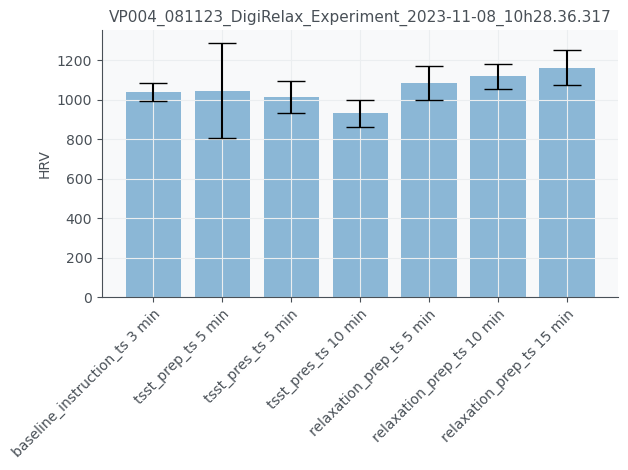

D:/Datasets/data_sony_digiRelax/study\VP005_081123\Psychopy_data\VP005_081123_DigiRelax_Experiment_2023-11-08_14h17.35.226.csv
VP005_081123_DigiRelax_Experiment_2023-11-08_14h17.35.226
baseline_instruction_ts 3 min
{'Mean RR (ms)': 915.1498067010309, 'STD RR/SDNN (ms)': 99.7539557213967, 'Mean HR (beats/min)': 66.4021213561736, 'STD HR (beats/min)': 7.7388119512491285, 'Min HR (beats/min)': 56.470588235294116, 'Max HR (beats/min)': 93.0909090909091, 'RMSSD (ms)': 76.09074350248957, 'NNxx': 100, 'pNNxx (%)': 51.54639175257732}
tsst_prep_ts 5 min
{'Mean RR (ms)': 651.2544253812637, 'STD RR/SDNN (ms)': 57.09412925742139, 'Mean HR (beats/min)': 92.80367962081965, 'STD HR (beats/min)': 7.734024055707315, 'Min HR (beats/min)': 71.44186046511628, 'Max HR (beats/min)': 114.6268656716418, 'RMSSD (ms)': 30.31708241485347, 'NNxx': 37, 'pNNxx (%)': 8.061002178649238}
tsst_pres_ts 5 min
{'Mean RR (ms)': 520.5538285340314, 'STD RR/SDNN (ms)': 60.4441964768645, 'Mean HR (beats/min)': 116.750542153337

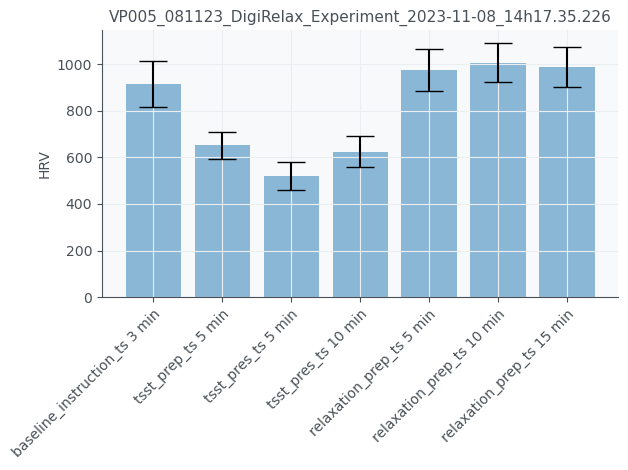

D:/Datasets/data_sony_digiRelax/study\VP006_091123\Psychopy_data\VP006_091123_DigiRelax_Experiment_2023-11-09_10h17.40.415.csv
VP006_091123_DigiRelax_Experiment_2023-11-09_10h17.40.415
baseline_instruction_ts 3 min
{'Mean RR (ms)': 640.022961469534, 'STD RR/SDNN (ms)': 39.22204534328211, 'Mean HR (beats/min)': 94.01117017258431, 'STD HR (beats/min)': 4.507306274374541, 'Min HR (beats/min)': 52.602739726027394, 'Max HR (beats/min)': 108.16901408450704, 'RMSSD (ms)': 43.95881524669921, 'NNxx': 2, 'pNNxx (%)': 0.7168458781362007}
tsst_prep_ts 5 min
{'Mean RR (ms)': 604.3142712550607, 'STD RR/SDNN (ms)': 24.835510404329856, 'Mean HR (beats/min)': 99.47421910127181, 'STD HR (beats/min)': 4.68334773026513, 'Min HR (beats/min)': 89.82456140350877, 'Max HR (beats/min)': 161.68421052631578, 'RMSSD (ms)': 16.946778862523963, 'NNxx': 4, 'pNNxx (%)': 0.8097165991902834}
tsst_pres_ts 5 min
{'Mean RR (ms)': 560.4514215225564, 'STD RR/SDNN (ms)': 30.349813995766194, 'Mean HR (beats/min)': 107.3877443

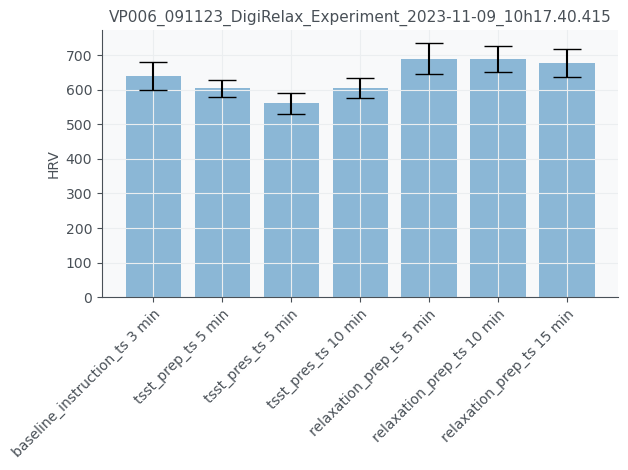

D:/Datasets/data_sony_digiRelax/study\VP007_091123\Psychopy_data\VP007_091123_DigiRelax_Experiment_2023-11-09_14h19.56.411.csv
VP007_091123_DigiRelax_Experiment_2023-11-09_14h19.56.411
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1228.8523706896551, 'STD RR/SDNN (ms)': 30.460757568608457, 'Mean HR (beats/min)': 48.85604348074669, 'STD HR (beats/min)': 1.2108989146004396, 'Min HR (beats/min)': 45.850746268656714, 'Max HR (beats/min)': 52.067796610169495, 'RMSSD (ms)': 19.915384802008372, 'NNxx': 1, 'pNNxx (%)': 0.6896551724137931}
tsst_prep_ts 5 min
{'Mean RR (ms)': 1078.2942238267149, 'STD RR/SDNN (ms)': 47.90458401438842, 'Mean HR (beats/min)': 55.756374443491005, 'STD HR (beats/min)': 2.5460430488260233, 'Min HR (beats/min)': 51.029900332225914, 'Max HR (beats/min)': 63.7344398340249, 'RMSSD (ms)': 20.60698126295954, 'NNxx': 6, 'pNNxx (%)': 2.1660649819494586}
tsst_pres_ts 5 min
{'Mean RR (ms)': 1003.6695075757576, 'STD RR/SDNN (ms)': 101.7264961328756, 'Mean HR (beats/min)': 60.23

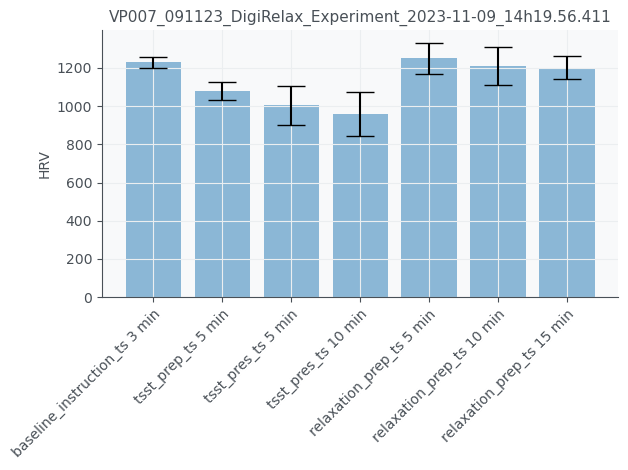

D:/Datasets/data_sony_digiRelax/study\VP008_101123\Psychopy_data\VP008_101123_DigiRelax_Experiment_2023-11-10_10h24.14.323.csv
VP008_101123_DigiRelax_Experiment_2023-11-10_10h24.14.323
baseline_instruction_ts 3 min
{'Mean RR (ms)': 934.9026505235602, 'STD RR/SDNN (ms)': 91.28494368382562, 'Mean HR (beats/min)': 64.7992544582452, 'STD HR (beats/min)': 6.395848188844711, 'Min HR (beats/min)': 53.333333333333336, 'Max HR (beats/min)': 78.76923076923077, 'RMSSD (ms)': 64.98083164037178, 'NNxx': 84, 'pNNxx (%)': 43.97905759162304}
tsst_prep_ts 5 min
{'Mean RR (ms)': 822.0235020661157, 'STD RR/SDNN (ms)': 101.5313204111027, 'Mean HR (beats/min)': 74.08707451858324, 'STD HR (beats/min)': 9.073539728068216, 'Min HR (beats/min)': 40.31496062992126, 'Max HR (beats/min)': 99.09677419354838, 'RMSSD (ms)': 68.88563341025102, 'NNxx': 92, 'pNNxx (%)': 25.34435261707989}
tsst_pres_ts 5 min
{'Mean RR (ms)': 796.75, 'STD RR/SDNN (ms)': 68.06764118170739, 'Mean HR (beats/min)': 75.86618170135715, 'STD HR

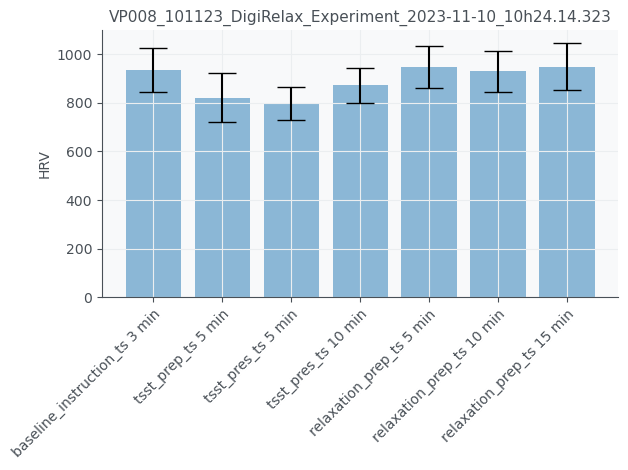

D:/Datasets/data_sony_digiRelax/study\VP009_101123\Psychopy_data\VP009_101123_DigiRelax_Experiment_2023-11-10_14h16.47.223.csv
VP009_101123_DigiRelax_Experiment_2023-11-10_14h16.47.223
baseline_instruction_ts 3 min
{'Mean RR (ms)': 918.8748389175257, 'STD RR/SDNN (ms)': 53.08821208609511, 'Mean HR (beats/min)': 65.51491383267698, 'STD HR (beats/min)': 3.7747667553458966, 'Min HR (beats/min)': 57.9622641509434, 'Max HR (beats/min)': 73.84615384615384, 'RMSSD (ms)': 38.78422578118897, 'NNxx': 44, 'pNNxx (%)': 22.68041237113402}
tsst_prep_ts 5 min
{'Mean RR (ms)': 706.181663711584, 'STD RR/SDNN (ms)': 78.17715608689318, 'Mean HR (beats/min)': 86.02619720067423, 'STD HR (beats/min)': 9.675457327270202, 'Min HR (beats/min)': 67.07423580786026, 'Max HR (beats/min)': 108.93617021276596, 'RMSSD (ms)': 37.645066006220624, 'NNxx': 76, 'pNNxx (%)': 17.96690307328605}
tsst_pres_ts 5 min
{'Mean RR (ms)': 569.5357313575525, 'STD RR/SDNN (ms)': 59.408256734908846, 'Mean HR (beats/min)': 106.482473163

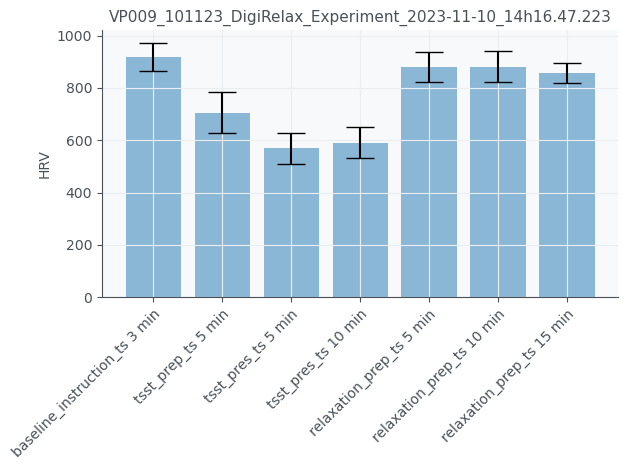

D:/Datasets/data_sony_digiRelax/study\VP010_131123\Psychopy_data\VP010_131123_DigiRelax_Experiment_2023-11-13_09h54.08.913.csv
VP010_131123_DigiRelax_Experiment_2023-11-13_09h54.08.913
baseline_instruction_ts 3 min
{'Mean RR (ms)': 743.9453125, 'STD RR/SDNN (ms)': 75.59434842307402, 'Mean HR (beats/min)': 81.50645520876076, 'STD HR (beats/min)': 8.548247400043904, 'Min HR (beats/min)': 64.53781512605042, 'Max HR (beats/min)': 133.56521739130434, 'RMSSD (ms)': 47.79353062250727, 'NNxx': 60, 'pNNxx (%)': 25.0}
tsst_prep_ts 5 min
{'Mean RR (ms)': 558.4401334269663, 'STD RR/SDNN (ms)': 65.36672554209885, 'Mean HR (beats/min)': 108.94058251213114, 'STD HR (beats/min)': 12.90073729432979, 'Min HR (beats/min)': 79.17525773195877, 'Max HR (beats/min)': 158.35051546391753, 'RMSSD (ms)': 17.694795027435866, 'NNxx': 6, 'pNNxx (%)': 1.1235955056179776}
tsst_pres_ts 5 min
{'Mean RR (ms)': 504.90429357022, 'STD RR/SDNN (ms)': 85.03269797621574, 'Mean HR (beats/min)': 121.06862291562982, 'STD HR (bea

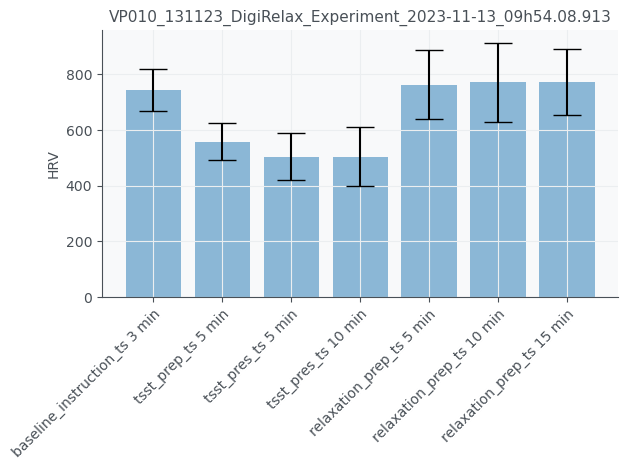

D:/Datasets/data_sony_digiRelax/study\VP011_131123\Psychopy_data\VP011_131123_DigiRelax_Experiment_2023-11-13_14h42.51.249.csv
VP011_131123_DigiRelax_Experiment_2023-11-13_14h42.51.249
baseline_instruction_ts 3 min
{'Mean RR (ms)': 888.6038557213931, 'STD RR/SDNN (ms)': 81.84557816267196, 'Mean HR (beats/min)': 68.07522600947809, 'STD HR (beats/min)': 6.043989481436212, 'Min HR (beats/min)': 54.08450704225352, 'Max HR (beats/min)': 81.26984126984127, 'RMSSD (ms)': 75.82553474094331, 'NNxx': 122, 'pNNxx (%)': 60.69651741293532}
tsst_prep_ts 5 min
{'Mean RR (ms)': 665.6719793986637, 'STD RR/SDNN (ms)': 71.74517285817245, 'Mean HR (beats/min)': 91.17450750419744, 'STD HR (beats/min)': 9.721722010206673, 'Min HR (beats/min)': 69.81818181818181, 'Max HR (beats/min)': 110.50359712230215, 'RMSSD (ms)': 24.37706459999106, 'NNxx': 24, 'pNNxx (%)': 5.3452115812917596}
tsst_pres_ts 5 min
{'Mean RR (ms)': 661.134977827051, 'STD RR/SDNN (ms)': 75.04420641517711, 'Mean HR (beats/min)': 91.7422642917

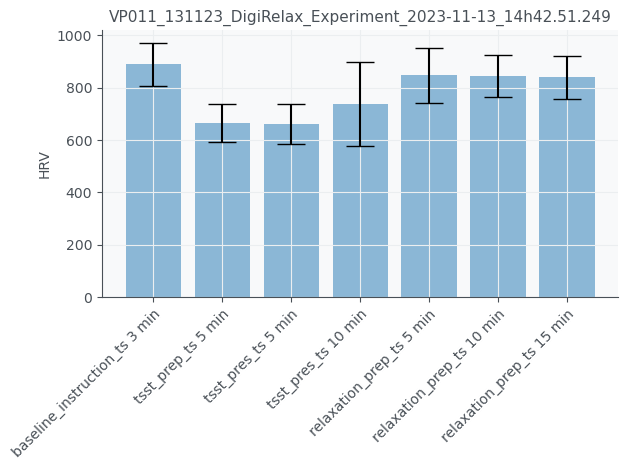

D:/Datasets/data_sony_digiRelax/study\VP012_141123\Psychopy_data\VP012_141123_DigiRelax_Experiment_2023-11-14_09h47.48.508.csv
VP012_141123_DigiRelax_Experiment_2023-11-14_09h47.48.508
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1082.2679924242425, 'STD RR/SDNN (ms)': 71.17876640425418, 'Mean HR (beats/min)': 55.685523333922326, 'STD HR (beats/min)': 3.7597552155481506, 'Min HR (beats/min)': 48.76190476190476, 'Max HR (beats/min)': 67.66519823788546, 'RMSSD (ms)': 75.59499048680206, 'NNxx': 104, 'pNNxx (%)': 63.03030303030303}
tsst_prep_ts 5 min
{'Mean RR (ms)': 896.4667792792793, 'STD RR/SDNN (ms)': 102.86820113770953, 'Mean HR (beats/min)': 67.8777142645919, 'STD HR (beats/min)': 8.393396039750288, 'Min HR (beats/min)': 47.701863354037265, 'Max HR (beats/min)': 100.3921568627451, 'RMSSD (ms)': 77.82173585154635, 'NNxx': 166, 'pNNxx (%)': 49.849849849849846}
tsst_pres_ts 5 min
{'Mean RR (ms)': 796.6243315508021, 'STD RR/SDNN (ms)': 91.82019662403202, 'Mean HR (beats/min)': 76.30033

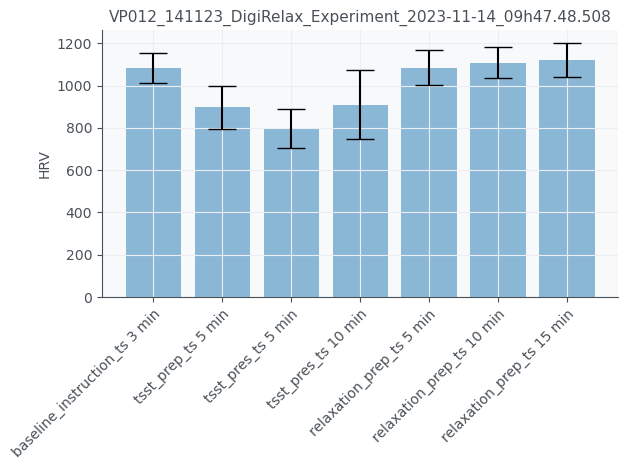

D:/Datasets/data_sony_digiRelax/study\VP013_151123\Psychopy_data\VP013_151123_DigiRelax_Experiment_2023-11-15_09h52.50.734.csv
VP013_151123_DigiRelax_Experiment_2023-11-15_09h52.50.734
baseline_instruction_ts 3 min
{'Mean RR (ms)': 597.066380033557, 'STD RR/SDNN (ms)': 24.632859447163327, 'Mean HR (beats/min)': 100.66584799605678, 'STD HR (beats/min)': 4.28664014055465, 'Min HR (beats/min)': 81.26984126984127, 'Max HR (beats/min)': 128.0, 'RMSSD (ms)': 37.446859707130386, 'NNxx': 16, 'pNNxx (%)': 5.369127516778524}
tsst_prep_ts 5 min
{'Mean RR (ms)': 587.6676304133858, 'STD RR/SDNN (ms)': 88.21373114437598, 'Mean HR (beats/min)': 103.42688204817541, 'STD HR (beats/min)': 9.388065201762174, 'Min HR (beats/min)': 48.301886792452834, 'Max HR (beats/min)': 180.7058823529412, 'RMSSD (ms)': 118.47823750326702, 'NNxx': 50, 'pNNxx (%)': 9.84251968503937}
tsst_pres_ts 5 min
{'Mean RR (ms)': 562.301377118644, 'STD RR/SDNN (ms)': 62.84014189685853, 'Mean HR (beats/min)': 107.4988218160059, 'STD H

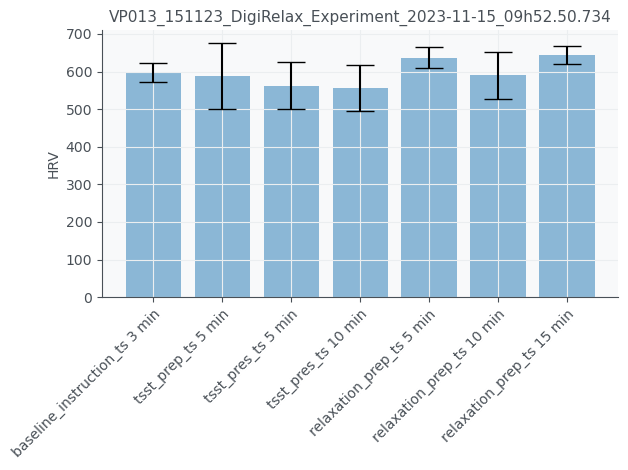

D:/Datasets/data_sony_digiRelax/study\VP014_151123\Psychopy_data\VP014_151123_DigiRelax_Experiment_2023-11-15_14h23.06.117.csv
VP014_151123_DigiRelax_Experiment_2023-11-15_14h23.06.117
baseline_instruction_ts 3 min
{'Mean RR (ms)': 736.9737861570248, 'STD RR/SDNN (ms)': 67.7913180154714, 'Mean HR (beats/min)': 82.20258470960158, 'STD HR (beats/min)': 9.847010998402466, 'Min HR (beats/min)': 44.26512968299712, 'Max HR (beats/min)': 194.43037974683546, 'RMSSD (ms)': 73.57744952659188, 'NNxx': 42, 'pNNxx (%)': 17.355371900826448}
tsst_prep_ts 5 min
{'Mean RR (ms)': 671.9627808988764, 'STD RR/SDNN (ms)': 108.45693642760239, 'Mean HR (beats/min)': 92.35972786290591, 'STD HR (beats/min)': 21.63970983583172, 'Min HR (beats/min)': 46.126126126126124, 'Max HR (beats/min)': 301.1764705882353, 'RMSSD (ms)': 117.33213554664482, 'NNxx': 140, 'pNNxx (%)': 31.46067415730337}
tsst_pres_ts 5 min
{'Mean RR (ms)': 695.7404574592075, 'STD RR/SDNN (ms)': 109.149382465388, 'Mean HR (beats/min)': 87.91983429

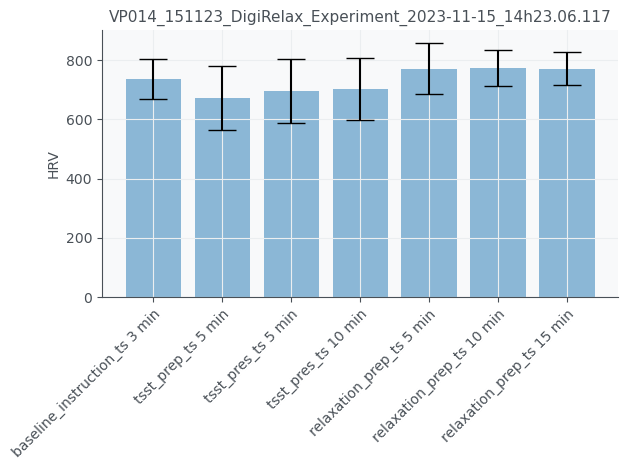

D:/Datasets/data_sony_digiRelax/study\VP015_161123\Psychopy_data\VP015_161123_DigiRelax_Experiment_2023-11-16_09h47.53.124.csv
VP015_161123_DigiRelax_Experiment_2023-11-16_09h47.53.124
baseline_instruction_ts 3 min
{'Mean RR (ms)': 834.6415011682243, 'STD RR/SDNN (ms)': 35.60109662724999, 'Mean HR (beats/min)': 72.03072857456537, 'STD HR (beats/min)': 3.406317190236481, 'Min HR (beats/min)': 66.49350649350649, 'Max HR (beats/min)': 101.72185430463576, 'RMSSD (ms)': 33.22226776607571, 'NNxx': 14, 'pNNxx (%)': 6.542056074766355}
tsst_prep_ts 5 min
{'Mean RR (ms)': 674.99469739819, 'STD RR/SDNN (ms)': 62.602951164940094, 'Mean HR (beats/min)': 89.67457417768966, 'STD HR (beats/min)': 8.536130292018505, 'Min HR (beats/min)': 71.44186046511628, 'Max HR (beats/min)': 114.6268656716418, 'RMSSD (ms)': 24.879744164245096, 'NNxx': 17, 'pNNxx (%)': 3.8461538461538463}
tsst_pres_ts 5 min
{'Mean RR (ms)': 571.502334770115, 'STD RR/SDNN (ms)': 77.5422336626211, 'Mean HR (beats/min)': 106.39758258909

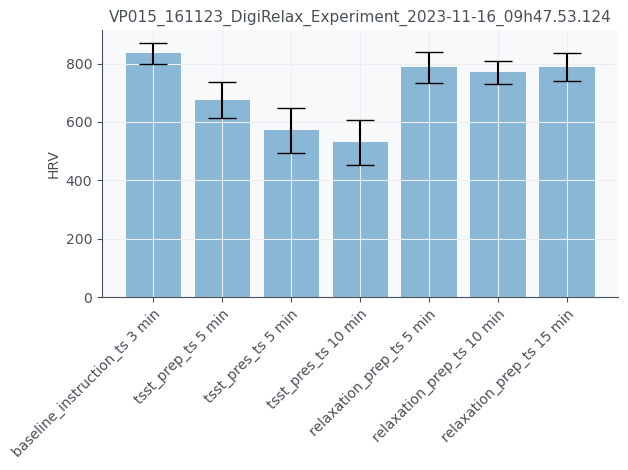

D:/Datasets/data_sony_digiRelax/study\VP016_161123\Psychopy_data\VP016_161123_DigiRelax_Experiment_2023-11-16_14h46.57.355.csv
VP016_161123_DigiRelax_Experiment_2023-11-16_14h46.57.355
baseline_instruction_ts 3 min
{'Mean RR (ms)': 727.2640306122449, 'STD RR/SDNN (ms)': 22.793689880288287, 'Mean HR (beats/min)': 82.58311713691691, 'STD HR (beats/min)': 2.6244155926066117, 'Min HR (beats/min)': 75.66502463054188, 'Max HR (beats/min)': 92.53012048192771, 'RMSSD (ms)': 15.334126581331429, 'NNxx': 0, 'pNNxx (%)': 0.0}
tsst_prep_ts 5 min
{'Mean RR (ms)': 767.4927699228792, 'STD RR/SDNN (ms)': 445.8636225369083, 'Mean HR (beats/min)': 101.11781336596766, 'STD HR (beats/min)': 135.22073374057717, 'Min HR (beats/min)': 15.578093306288032, 'Max HR (beats/min)': 2560.0, 'RMSSD (ms)': 568.810268591401, 'NNxx': 161, 'pNNxx (%)': 41.38817480719794}
tsst_pres_ts 5 min
{'Mean RR (ms)': 696.4324737762238, 'STD RR/SDNN (ms)': 155.88509690971713, 'Mean HR (beats/min)': 89.15730078062634, 'STD HR (beats/

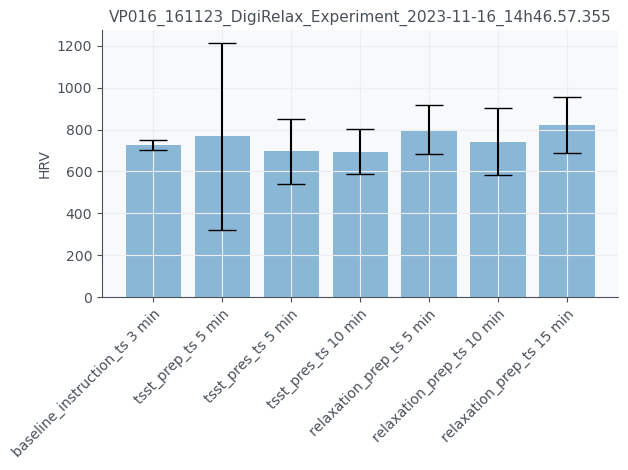

D:/Datasets/data_sony_digiRelax/study\VP017_171123\Psychopy_data\VP017_171123_DigiRelax_Experiment_2023-11-17_14h43.13.415.csv
VP017_171123_DigiRelax_Experiment_2023-11-17_14h43.13.415
baseline_instruction_ts 3 min
{'Mean RR (ms)': 975.0042691256831, 'STD RR/SDNN (ms)': 87.710249498352, 'Mean HR (beats/min)': 62.04737814106673, 'STD HR (beats/min)': 5.694404308344091, 'Min HR (beats/min)': 49.70873786407767, 'Max HR (beats/min)': 78.36734693877551, 'RMSSD (ms)': 67.89573688297277, 'NNxx': 96, 'pNNxx (%)': 52.459016393442624}
tsst_prep_ts 5 min
{'Mean RR (ms)': 689.9087038106236, 'STD RR/SDNN (ms)': 80.0711078937043, 'Mean HR (beats/min)': 88.0770134807137, 'STD HR (beats/min)': 9.646265288957878, 'Min HR (beats/min)': 63.47107438016529, 'Max HR (beats/min)': 112.11678832116789, 'RMSSD (ms)': 49.313630829264234, 'NNxx': 100, 'pNNxx (%)': 23.094688221709006}
tsst_pres_ts 5 min
{'Mean RR (ms)': 722.4571450242719, 'STD RR/SDNN (ms)': 103.79484147756821, 'Mean HR (beats/min)': 84.7218362809

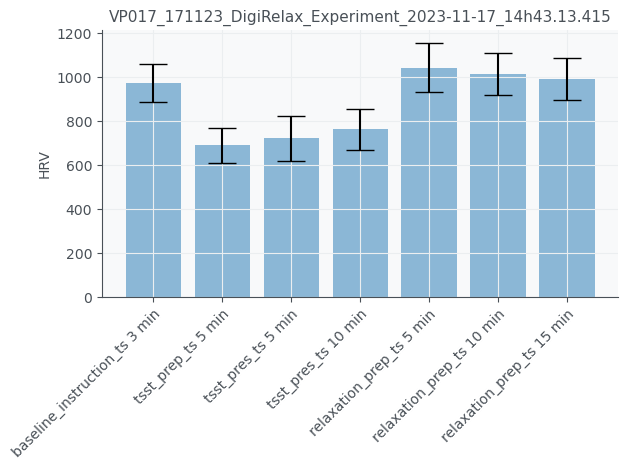

D:/Datasets/data_sony_digiRelax/study\VP018_201123\Psychopy_data\VP018_201123_DigiRelax_Experiment_2023-11-20_09h51.59.612.csv
VP018_201123_DigiRelax_Experiment_2023-11-20_09h51.59.612
baseline_instruction_ts 3 min
{'Mean RR (ms)': 699.7242647058823, 'STD RR/SDNN (ms)': 59.827557965938034, 'Mean HR (beats/min)': 86.17900324036331, 'STD HR (beats/min)': 5.362886702361648, 'Min HR (beats/min)': 41.85286103542234, 'Max HR (beats/min)': 113.77777777777777, 'RMSSD (ms)': 64.88022302790989, 'NNxx': 17, 'pNNxx (%)': 6.666666666666667}
tsst_prep_ts 5 min
{'Mean RR (ms)': 688.1390408986175, 'STD RR/SDNN (ms)': 84.04314803815146, 'Mean HR (beats/min)': 89.52193168849924, 'STD HR (beats/min)': 30.14499155406724, 'Min HR (beats/min)': 45.850746268656714, 'Max HR (beats/min)': 667.8260869565217, 'RMSSD (ms)': 99.78129586117252, 'NNxx': 46, 'pNNxx (%)': 10.599078341013826}
tsst_pres_ts 5 min
{'Mean RR (ms)': 724.315458131068, 'STD RR/SDNN (ms)': 182.30144114150505, 'Mean HR (beats/min)': 86.16136500

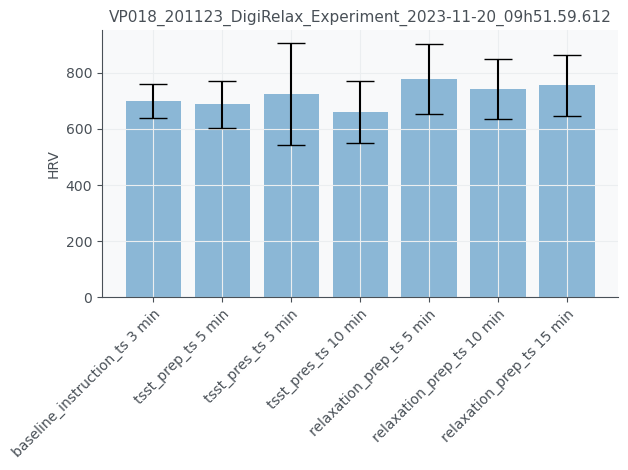

D:/Datasets/data_sony_digiRelax/study\VP019_201123\Psychopy_data\VP019_201123_DigiRelax_Experiment_2023-11-20_14h48.37.367.csv
VP019_201123_DigiRelax_Experiment_2023-11-20_14h48.37.367
baseline_instruction_ts 3 min
{'Mean RR (ms)': 919.579574742268, 'STD RR/SDNN (ms)': 22.89599821071992, 'Mean HR (beats/min)': 65.28851931208565, 'STD HR (beats/min)': 1.6606013946329439, 'Min HR (beats/min)': 60.95238095238095, 'Max HR (beats/min)': 71.77570093457943, 'RMSSD (ms)': 15.277051995766302, 'NNxx': 0, 'pNNxx (%)': 0.0}
tsst_prep_ts 5 min
{'Mean RR (ms)': 805.7643581081081, 'STD RR/SDNN (ms)': 34.893609487038184, 'Mean HR (beats/min)': 74.6020856924438, 'STD HR (beats/min)': 3.2083572071346294, 'Min HR (beats/min)': 64.81012658227849, 'Max HR (beats/min)': 84.3956043956044, 'RMSSD (ms)': 20.15230405588923, 'NNxx': 5, 'pNNxx (%)': 1.3513513513513513}
tsst_pres_ts 5 min
{'Mean RR (ms)': 751.4267159949623, 'STD RR/SDNN (ms)': 53.930971331081125, 'Mean HR (beats/min)': 80.28007516981181, 'STD HR (

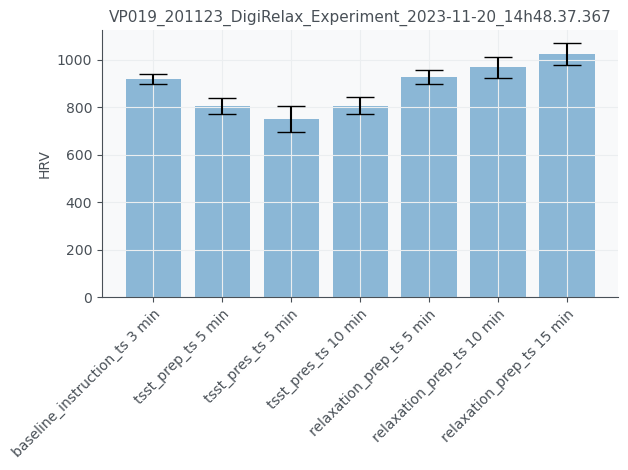

D:/Datasets/data_sony_digiRelax/study\VP020_221123\Psychopy_data\VP020_221123_DigiRelax_Experiment_2023-11-22_09h48.04.766.csv
VP020_221123_DigiRelax_Experiment_2023-11-22_09h48.04.766
baseline_instruction_ts 3 min
{'Mean RR (ms)': 964.9704391891892, 'STD RR/SDNN (ms)': 72.56606159416764, 'Mean HR (beats/min)': 62.528379047040644, 'STD HR (beats/min)': 4.675225749580496, 'Min HR (beats/min)': 52.78350515463917, 'Max HR (beats/min)': 72.79620853080569, 'RMSSD (ms)': 70.3077821484833, 'NNxx': 85, 'pNNxx (%)': 45.945945945945944}
tsst_prep_ts 5 min
{'Mean RR (ms)': 790.0571949602122, 'STD RR/SDNN (ms)': 83.10490715056942, 'Mean HR (beats/min)': 77.18731673088757, 'STD HR (beats/min)': 13.699838918488892, 'Min HR (beats/min)': 56.26373626373626, 'Max HR (beats/min)': 240.0, 'RMSSD (ms)': 70.68379085007986, 'NNxx': 102, 'pNNxx (%)': 27.05570291777188}
tsst_pres_ts 5 min
{'Mean RR (ms)': 699.0723799765808, 'STD RR/SDNN (ms)': 76.98492104957982, 'Mean HR (beats/min)': 87.20672866895755, 'STD 

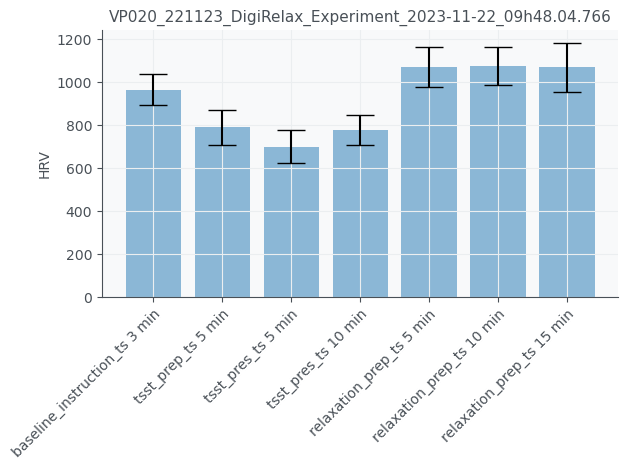

D:/Datasets/data_sony_digiRelax/study\VP021_221123\Psychopy_data\VP021_221123_DigiRelax_Experiment_2023-11-22_14h43.57.344.csv
VP021_221123_DigiRelax_Experiment_2023-11-22_14h43.57.344
baseline_instruction_ts 3 min
{'Mean RR (ms)': 716.203125, 'STD RR/SDNN (ms)': 114.31444883692798, 'Mean HR (beats/min)': 85.40300376046734, 'STD HR (beats/min)': 10.366171273254201, 'Min HR (beats/min)': 49.38906752411575, 'Max HR (beats/min)': 102.4, 'RMSSD (ms)': 91.78310546241366, 'NNxx': 66, 'pNNxx (%)': 26.4}
tsst_prep_ts 5 min
{'Mean RR (ms)': 605.6509888438134, 'STD RR/SDNN (ms)': 42.252893523372954, 'Mean HR (beats/min)': 99.54480788785848, 'STD HR (beats/min)': 6.996184877487626, 'Min HR (beats/min)': 72.45283018867924, 'Max HR (beats/min)': 161.68421052631578, 'RMSSD (ms)': 28.51525521115615, 'NNxx': 17, 'pNNxx (%)': 3.4482758620689653}
tsst_pres_ts 5 min
{'Mean RR (ms)': 544.6011062956204, 'STD RR/SDNN (ms)': 54.611915582140675, 'Mean HR (beats/min)': 111.23164515067026, 'STD HR (beats/min)':

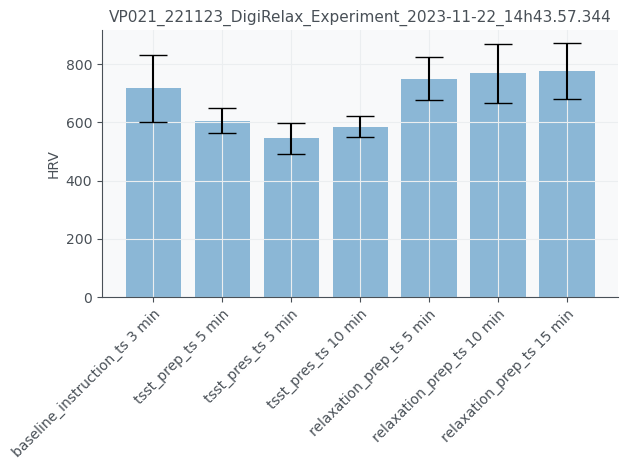

D:/Datasets/data_sony_digiRelax/study\VP022_231123\Psychopy_data\VP022_231123_DigiRelax_Experiment_2023-11-23_09h47.27.026.csv
VP022_231123_DigiRelax_Experiment_2023-11-23_09h47.27.026
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1246.2576486013986, 'STD RR/SDNN (ms)': 75.05989315423639, 'Mean HR (beats/min)': 48.32832113616689, 'STD HR (beats/min)': 3.069720597226403, 'Min HR (beats/min)': 43.146067415730336, 'Max HR (beats/min)': 58.85057471264368, 'RMSSD (ms)': 102.83579372183854, 'NNxx': 93, 'pNNxx (%)': 65.03496503496504}
tsst_prep_ts 5 min
{'Mean RR (ms)': 918.9182692307693, 'STD RR/SDNN (ms)': 108.1446503781759, 'Mean HR (beats/min)': 66.12143387643748, 'STD HR (beats/min)': 7.153321507154323, 'Min HR (beats/min)': 40.421052631578945, 'Max HR (beats/min)': 84.3956043956044, 'RMSSD (ms)': 92.06173210779443, 'NNxx': 156, 'pNNxx (%)': 48.0}
tsst_pres_ts 5 min
{'Mean RR (ms)': 729.6836703431372, 'STD RR/SDNN (ms)': 147.88210801765746, 'Mean HR (beats/min)': 85.63109708263856, 'STD

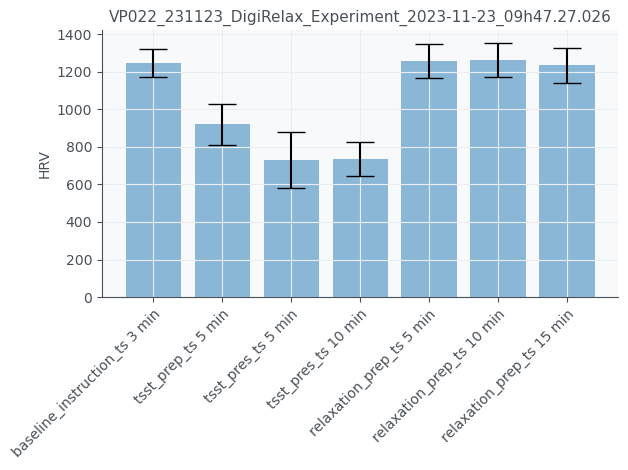

D:/Datasets/data_sony_digiRelax/study\VP023_231123\Psychopy_data\VP023_231123_DigiRelax_Experiment_2023-11-23_14h49.16.111.csv
VP023_231123_DigiRelax_Experiment_2023-11-23_14h49.16.111
baseline_instruction_ts 3 min
{'Mean RR (ms)': 860.9224033816425, 'STD RR/SDNN (ms)': 100.81344107019345, 'Mean HR (beats/min)': 70.65170577196814, 'STD HR (beats/min)': 8.278177081142832, 'Min HR (beats/min)': 52.96551724137931, 'Max HR (beats/min)': 95.40372670807453, 'RMSSD (ms)': 118.73472931322559, 'NNxx': 134, 'pNNxx (%)': 64.73429951690821}
tsst_prep_ts 5 min
{'Mean RR (ms)': 623.1204236401674, 'STD RR/SDNN (ms)': 81.91507189147035, 'Mean HR (beats/min)': 97.50024018606808, 'STD HR (beats/min)': 9.812537260579687, 'Min HR (beats/min)': 40.31496062992126, 'Max HR (beats/min)': 142.22222222222223, 'RMSSD (ms)': 80.54886889939279, 'NNxx': 89, 'pNNxx (%)': 18.619246861924687}
tsst_pres_ts 5 min
{'Mean RR (ms)': 537.214759442446, 'STD RR/SDNN (ms)': 117.0209439283892, 'Mean HR (beats/min)': 114.8208889

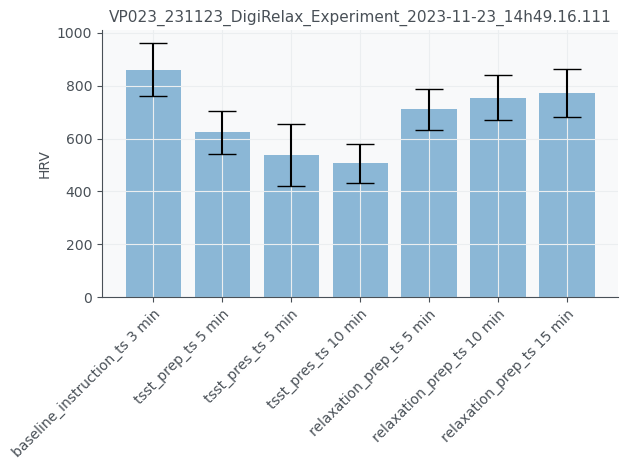

D:/Datasets/data_sony_digiRelax/study\VP024_241123\Psychopy_data\VP024_241123_DigiRelax_Experiment_2023-11-24_15h57.15.078.csv
VP024_241123_DigiRelax_Experiment_2023-11-24_15h57.15.078
baseline_instruction_ts 3 min
{'Mean RR (ms)': 681.7300811068702, 'STD RR/SDNN (ms)': 41.93805426661697, 'Mean HR (beats/min)': 88.27994633556008, 'STD HR (beats/min)': 4.489079616560946, 'Min HR (beats/min)': 52.602739726027394, 'Max HR (beats/min)': 97.8343949044586, 'RMSSD (ms)': 47.34286188202563, 'NNxx': 16, 'pNNxx (%)': 6.106870229007634}
tsst_prep_ts 5 min
{'Mean RR (ms)': 655.2455357142857, 'STD RR/SDNN (ms)': 64.65810527711807, 'Mean HR (beats/min)': 92.36806238852529, 'STD HR (beats/min)': 8.324219388351763, 'Min HR (beats/min)': 59.07692307692308, 'Max HR (beats/min)': 155.15151515151516, 'RMSSD (ms)': 51.6146325904086, 'NNxx': 57, 'pNNxx (%)': 12.527472527472527}
tsst_pres_ts 5 min
{'Mean RR (ms)': 576.3528595559845, 'STD RR/SDNN (ms)': 34.2962724132269, 'Mean HR (beats/min)': 104.47219239197

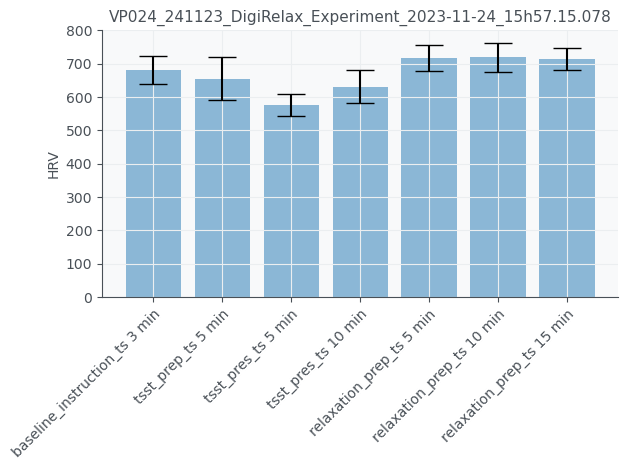

D:/Datasets/data_sony_digiRelax/study\VP025_271123\Psychopy_data\VP025_271123_DigiRelax_Experiment_2023-11-27_09h46.03.287.csv
VP025_271123_DigiRelax_Experiment_2023-11-27_09h46.03.287
baseline_instruction_ts 3 min
{'Mean RR (ms)': 967.3775337837837, 'STD RR/SDNN (ms)': 198.77134988305437, 'Mean HR (beats/min)': 63.56471051473121, 'STD HR (beats/min)': 7.769294400179008, 'Min HR (beats/min)': 30.536779324055665, 'Max HR (beats/min)': 77.96954314720813, 'RMSSD (ms)': 272.65482657766603, 'NNxx': 87, 'pNNxx (%)': 47.027027027027025}
tsst_prep_ts 5 min
{'Mean RR (ms)': 651.3629230349345, 'STD RR/SDNN (ms)': 75.97953977368702, 'Mean HR (beats/min)': 92.92631257904885, 'STD HR (beats/min)': 7.515619413584185, 'Min HR (beats/min)': 41.40161725067385, 'Max HR (beats/min)': 150.58823529411765, 'RMSSD (ms)': 88.91262606543124, 'NNxx': 29, 'pNNxx (%)': 6.331877729257642}
tsst_pres_ts 5 min
{'Mean RR (ms)': 683.7370986238532, 'STD RR/SDNN (ms)': 244.6501572857703, 'Mean HR (beats/min)': 95.5700979

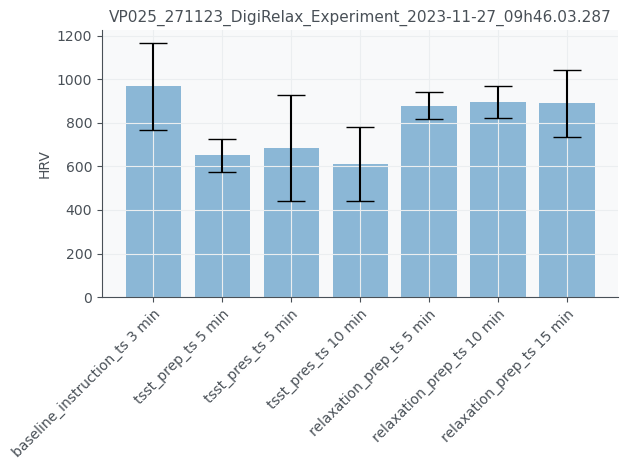

D:/Datasets/data_sony_digiRelax/study\VP026_271123\Psychopy_data\VP26_271123_DigiRelax_Experiment_2023-11-27_13h16.52.357.csv
VP26_271123_DigiRelax_Experiment_2023-11-27_13h16.52.357
baseline_instruction_ts 3 min
{'Mean RR (ms)': 758.1948138297872, 'STD RR/SDNN (ms)': 274.0784600308051, 'Mean HR (beats/min)': 94.52954541493345, 'STD HR (beats/min)': 46.34520518403954, 'Min HR (beats/min)': 46.972477064220186, 'Max HR (beats/min)': 196.92307692307693, 'RMSSD (ms)': 359.8424733857541, 'NNxx': 212, 'pNNxx (%)': 90.2127659574468}
tsst_prep_ts 5 min
{'Mean RR (ms)': 818.3701064560439, 'STD RR/SDNN (ms)': 445.04775899432457, 'Mean HR (beats/min)': 98.50540952061836, 'STD HR (beats/min)': 60.459320298123565, 'Min HR (beats/min)': 19.768339768339768, 'Max HR (beats/min)': 465.45454545454544, 'RMSSD (ms)': 575.285844554005, 'NNxx': 317, 'pNNxx (%)': 87.08791208791209}
tsst_pres_ts 5 min
{'Mean RR (ms)': 729.2749083129585, 'STD RR/SDNN (ms)': 337.86603218446163, 'Mean HR (beats/min)': 101.009939

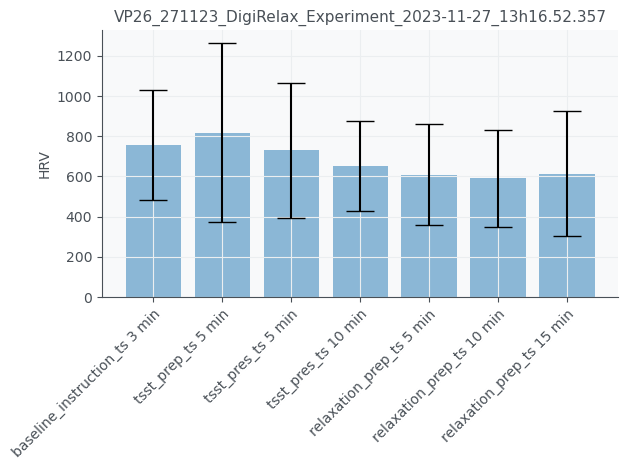

D:/Datasets/data_sony_digiRelax/study\VP027_271123\Psychopy_data\VP027_271123_DigiRelax_Experiment_2023-11-27_15h58.18.227.csv
VP027_271123_DigiRelax_Experiment_2023-11-27_15h58.18.227
baseline_instruction_ts 3 min
{'Mean RR (ms)': 788.9415099557522, 'STD RR/SDNN (ms)': 38.54116922158683, 'Mean HR (beats/min)': 76.234847923031, 'STD HR (beats/min)': 3.7692098388674133, 'Min HR (beats/min)': 64.26778242677824, 'Max HR (beats/min)': 89.30232558139535, 'RMSSD (ms)': 27.19578018865141, 'NNxx': 15, 'pNNxx (%)': 6.6371681415929205}
tsst_prep_ts 5 min
{'Mean RR (ms)': 748.1986215538847, 'STD RR/SDNN (ms)': 54.34135520569996, 'Mean HR (beats/min)': 80.63785109133289, 'STD HR (beats/min)': 6.185561033318778, 'Min HR (beats/min)': 63.20987654320987, 'Max HR (beats/min)': 114.6268656716418, 'RMSSD (ms)': 38.05226323053703, 'NNxx': 36, 'pNNxx (%)': 9.022556390977444}
tsst_pres_ts 5 min
{'Mean RR (ms)': 772.3445595854922, 'STD RR/SDNN (ms)': 51.1001062060232, 'Mean HR (beats/min)': 78.0299413031704

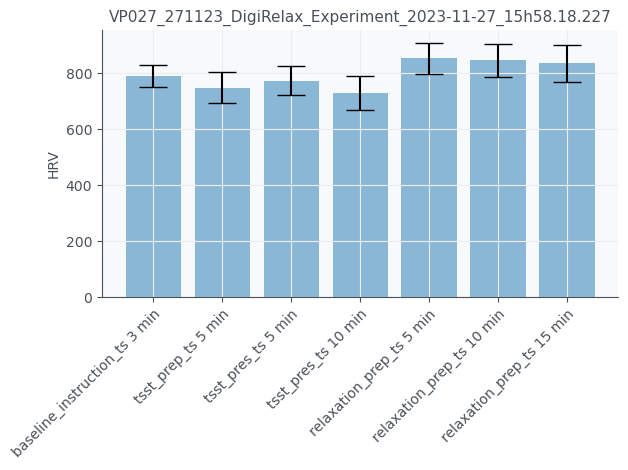

D:/Datasets/data_sony_digiRelax/study\VP028_281123\Psychopy_data\VP028_281123_DigiRelax_Experiment_2023-11-28_13h11.36.660.csv
VP028_281123_DigiRelax_Experiment_2023-11-28_13h11.36.660
baseline_instruction_ts 3 min
{'Mean RR (ms)': 853.9735346889952, 'STD RR/SDNN (ms)': 62.41079463394616, 'Mean HR (beats/min)': 70.64403300454333, 'STD HR (beats/min)': 5.276584422204283, 'Min HR (beats/min)': 61.19521912350598, 'Max HR (beats/min)': 84.86187845303867, 'RMSSD (ms)': 50.22637400393276, 'NNxx': 85, 'pNNxx (%)': 40.66985645933014}
tsst_prep_ts 5 min
{'Mean RR (ms)': 656.774848568282, 'STD RR/SDNN (ms)': 80.49116842066356, 'Mean HR (beats/min)': 93.88004696377277, 'STD HR (beats/min)': 24.73874314397877, 'Min HR (beats/min)': 44.39306358381503, 'Max HR (beats/min)': 357.2093023255814, 'RMSSD (ms)': 94.86437578483483, 'NNxx': 53, 'pNNxx (%)': 11.674008810572687}
tsst_pres_ts 5 min
{'Mean RR (ms)': 712.6901849642005, 'STD RR/SDNN (ms)': 286.32728154538546, 'Mean HR (beats/min)': 93.13144700375

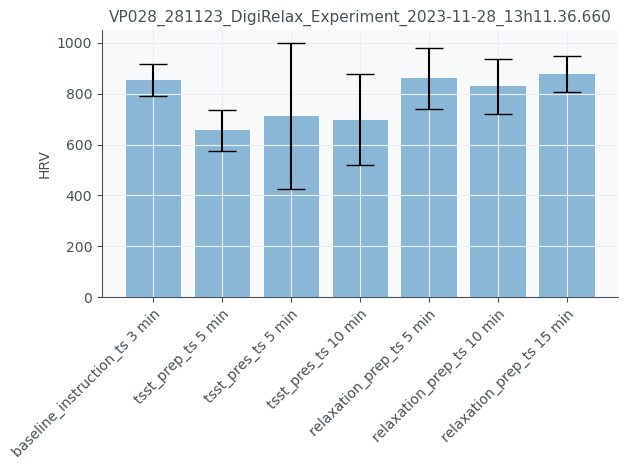

D:/Datasets/data_sony_digiRelax/study\VP029_281123\Psychopy_data\VP029_281123_DigiRelax_Experiment_2023-11-28_15h49.00.382.csv
VP029_281123_DigiRelax_Experiment_2023-11-28_15h49.00.382
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1270.8426339285713, 'STD RR/SDNN (ms)': 67.82975755665146, 'Mean HR (beats/min)': 47.357301331247015, 'STD HR (beats/min)': 2.7271680751179352, 'Min HR (beats/min)': 42.54847645429363, 'Max HR (beats/min)': 61.19521912350598, 'RMSSD (ms)': 95.87917732814255, 'NNxx': 80, 'pNNxx (%)': 57.142857142857146}
tsst_prep_ts 5 min
{'Mean RR (ms)': 920.9346064814815, 'STD RR/SDNN (ms)': 164.22506824021278, 'Mean HR (beats/min)': 67.48881666200975, 'STD HR (beats/min)': 16.222400159168487, 'Min HR (beats/min)': 27.1858407079646, 'Max HR (beats/min)': 213.33333333333334, 'RMSSD (ms)': 188.37888720672703, 'NNxx': 132, 'pNNxx (%)': 40.74074074074074}
tsst_pres_ts 5 min
{'Mean RR (ms)': 825.3873788088642, 'STD RR/SDNN (ms)': 128.30918953125808, 'Mean HR (beats/min)': 74.106

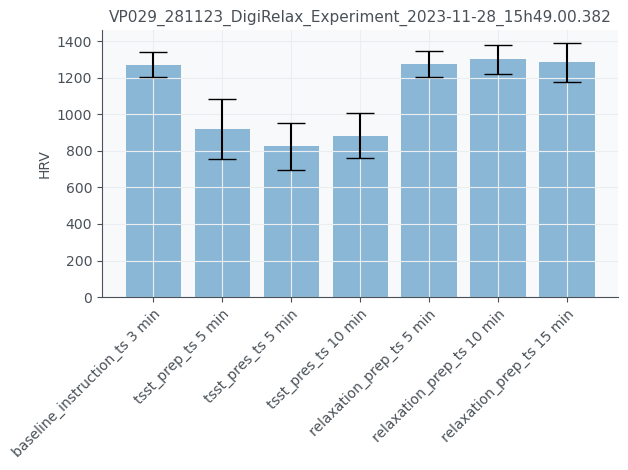

D:/Datasets/data_sony_digiRelax/study\VP030_291123\Psychopy_data\VP030_291123_DigiRelax_Experiment_2023-11-29_09h54.53.886.csv
VP030_291123_DigiRelax_Experiment_2023-11-29_09h54.53.886
baseline_instruction_ts 3 min
{'Mean RR (ms)': 809.765625, 'STD RR/SDNN (ms)': 46.558918934516214, 'Mean HR (beats/min)': 74.33975750980473, 'STD HR (beats/min)': 4.257810755300502, 'Min HR (beats/min)': 64.53781512605042, 'Max HR (beats/min)': 83.93442622950819, 'RMSSD (ms)': 37.73149774368917, 'NNxx': 47, 'pNNxx (%)': 21.363636363636363}
tsst_prep_ts 5 min
{'Mean RR (ms)': 603.1092171717172, 'STD RR/SDNN (ms)': 48.232523357757515, 'Mean HR (beats/min)': 100.10052835012638, 'STD HR (beats/min)': 7.852495468620341, 'Min HR (beats/min)': 58.40304182509506, 'Max HR (beats/min)': 135.92920353982302, 'RMSSD (ms)': 36.89504849173174, 'NNxx': 6, 'pNNxx (%)': 1.2121212121212122}
tsst_pres_ts 5 min
{'Mean RR (ms)': 513.6651400862069, 'STD RR/SDNN (ms)': 45.242832480530026, 'Mean HR (beats/min)': 117.503587226177

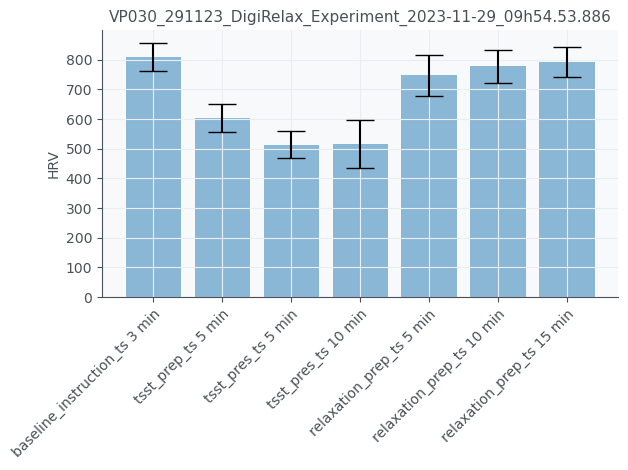

D:/Datasets/data_sony_digiRelax/study\VP031_291123\Psychopy_data\VP031_291123_DigiRelax_Experiment_2023-11-29_14h41.15.470.csv
VP031_291123_DigiRelax_Experiment_2023-11-29_14h41.15.470
baseline_instruction_ts 3 min
{'Mean RR (ms)': 910.2160395408164, 'STD RR/SDNN (ms)': 71.9038026502518, 'Mean HR (beats/min)': 66.35716164510227, 'STD HR (beats/min)': 5.610830321988411, 'Min HR (beats/min)': 54.661921708185055, 'Max HR (beats/min)': 89.30232558139535, 'RMSSD (ms)': 67.62179349980158, 'NNxx': 96, 'pNNxx (%)': 48.97959183673469}
tsst_prep_ts 5 min
{'Mean RR (ms)': 841.9784330985915, 'STD RR/SDNN (ms)': 83.28368371895675, 'Mean HR (beats/min)': 71.99956629788136, 'STD HR (beats/min)': 7.572425080262868, 'Min HR (beats/min)': 54.857142857142854, 'Max HR (beats/min)': 113.77777777777777, 'RMSSD (ms)': 60.94618559533579, 'NNxx': 141, 'pNNxx (%)': 39.71830985915493}
tsst_pres_ts 5 min
{'Mean RR (ms)': 722.5143765133172, 'STD RR/SDNN (ms)': 61.26606844434613, 'Mean HR (beats/min)': 83.625149031

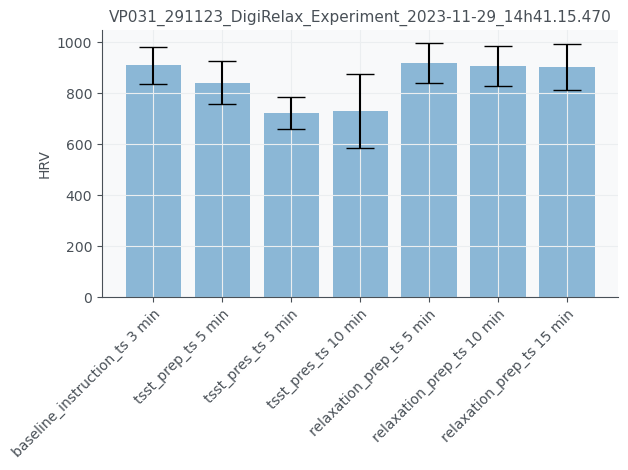

D:/Datasets/data_sony_digiRelax/study\VP032_301123\Psychopy_data\VP032_301123_DigiRelax_Experiment_2023-11-30_09h49.51.787.csv
VP032_301123_DigiRelax_Experiment_2023-11-30_09h49.51.787
baseline_instruction_ts 3 min
{'Mean RR (ms)': 757.2828389830509, 'STD RR/SDNN (ms)': 98.39684124223825, 'Mean HR (beats/min)': 80.29262438229064, 'STD HR (beats/min)': 8.548525900283824, 'Min HR (beats/min)': 36.74641148325359, 'Max HR (beats/min)': 96.60377358490567, 'RMSSD (ms)': 106.55469306352974, 'NNxx': 91, 'pNNxx (%)': 38.559322033898304}
tsst_prep_ts 5 min
{'Mean RR (ms)': 563.8586956521739, 'STD RR/SDNN (ms)': 35.12054149035647, 'Mean HR (beats/min)': 106.73467319229971, 'STD HR (beats/min)': 5.4646168785302836, 'Min HR (beats/min)': 55.45126353790614, 'Max HR (beats/min)': 149.126213592233, 'RMSSD (ms)': 32.067895242797434, 'NNxx': 13, 'pNNxx (%)': 2.4574669187145557}
tsst_pres_ts 5 min
{'Mean RR (ms)': 519.5652173913044, 'STD RR/SDNN (ms)': 65.10227824923476, 'Mean HR (beats/min)': 117.186028

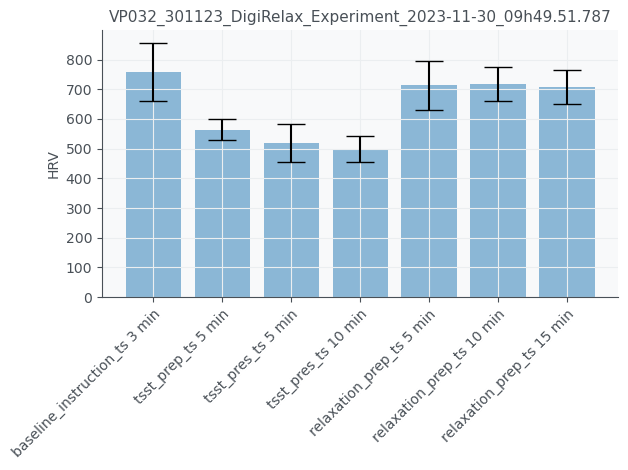

D:/Datasets/data_sony_digiRelax/study\VP033_301123\Psychopy_data\VP033_301123_DigiRelax_Experiment_2023-11-30_15h44.58.284.csv
VP033_301123_DigiRelax_Experiment_2023-11-30_15h44.58.284
baseline_instruction_ts 3 min
{'Mean RR (ms)': 771.678841991342, 'STD RR/SDNN (ms)': 64.4753746857419, 'Mean HR (beats/min)': 78.23741157692945, 'STD HR (beats/min)': 5.930369079906082, 'Min HR (beats/min)': 46.829268292682926, 'Max HR (beats/min)': 93.0909090909091, 'RMSSD (ms)': 67.49477495250981, 'NNxx': 87, 'pNNxx (%)': 37.66233766233766}
tsst_prep_ts 5 min
{'Mean RR (ms)': 630.6487843551797, 'STD RR/SDNN (ms)': 70.4978130565337, 'Mean HR (beats/min)': 96.40804427023188, 'STD HR (beats/min)': 12.282620864905518, 'Min HR (beats/min)': 50.36065573770492, 'Max HR (beats/min)': 232.72727272727272, 'RMSSD (ms)': 62.54601804944394, 'NNxx': 80, 'pNNxx (%)': 16.913319238900634}
tsst_pres_ts 5 min
{'Mean RR (ms)': 605.4449797160244, 'STD RR/SDNN (ms)': 69.67906995413887, 'Mean HR (beats/min)': 100.38791046691

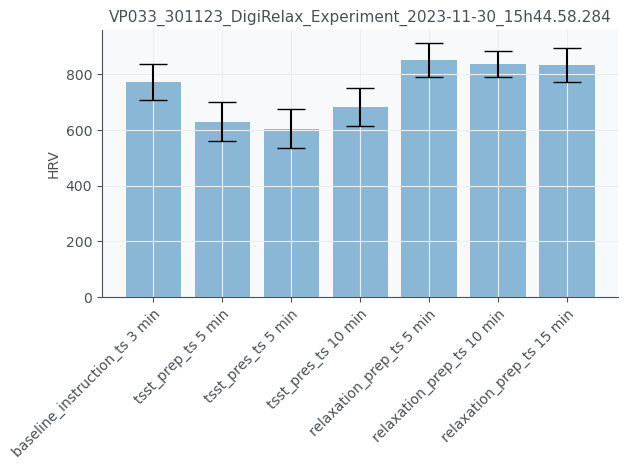

D:/Datasets/data_sony_digiRelax/study\VP034_011223\Psychopy_data\VP034_011223_DigiRelax_Experiment_2023-12-01_14h41.10.723.csv
VP034_011223_DigiRelax_Experiment_2023-12-01_14h41.10.723
baseline_instruction_ts 3 min
{'Mean RR (ms)': 937.6850328947369, 'STD RR/SDNN (ms)': 61.15599382627064, 'Mean HR (beats/min)': 64.28767406082548, 'STD HR (beats/min)': 4.66866645010023, 'Min HR (beats/min)': 55.45126353790614, 'Max HR (beats/min)': 96.0, 'RMSSD (ms)': 51.97471312473161, 'NNxx': 44, 'pNNxx (%)': 23.157894736842106}
tsst_prep_ts 5 min
{'Mean RR (ms)': 646.6703869047619, 'STD RR/SDNN (ms)': 100.07694675611515, 'Mean HR (beats/min)': 95.43016691724863, 'STD HR (beats/min)': 19.284939925360366, 'Min HR (beats/min)': 66.20689655172414, 'Max HR (beats/min)': 320.0, 'RMSSD (ms)': 64.43405696792748, 'NNxx': 87, 'pNNxx (%)': 18.83116883116883}
tsst_pres_ts 5 min
{'Mean RR (ms)': 586.2674975442043, 'STD RR/SDNN (ms)': 73.14717967892516, 'Mean HR (beats/min)': 103.9559853309809, 'STD HR (beats/min)

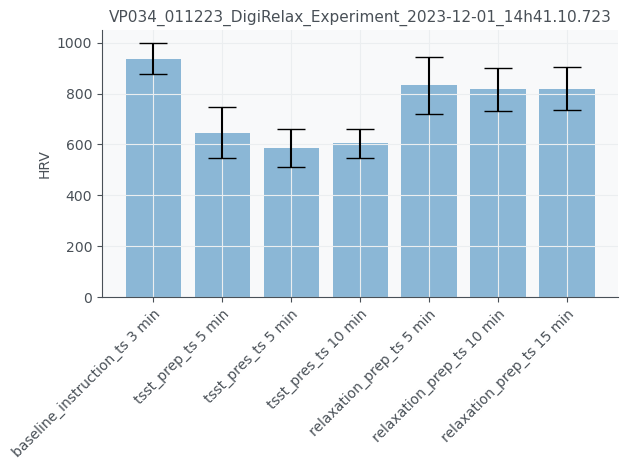

D:/Datasets/data_sony_digiRelax/study\VP035_041223\Psychopy_data\VP035_041123_DigiRelax_Experiment_2023-12-04_09h54.08.642.csv
VP035_041123_DigiRelax_Experiment_2023-12-04_09h54.08.642
baseline_instruction_ts 3 min
{'Mean RR (ms)': 912.1794871794872, 'STD RR/SDNN (ms)': 77.7961262886673, 'Mean HR (beats/min)': 66.25083555244188, 'STD HR (beats/min)': 5.63908236701341, 'Min HR (beats/min)': 44.52173913043478, 'Max HR (beats/min)': 86.29213483146067, 'RMSSD (ms)': 74.85137580734839, 'NNxx': 87, 'pNNxx (%)': 44.61538461538461}
tsst_prep_ts 5 min
{'Mean RR (ms)': 648.5054347826087, 'STD RR/SDNN (ms)': 95.76217899727182, 'Mean HR (beats/min)': 94.55480384819002, 'STD HR (beats/min)': 15.491850361774372, 'Min HR (beats/min)': 44.78134110787172, 'Max HR (beats/min)': 260.33898305084745, 'RMSSD (ms)': 112.45182938804145, 'NNxx': 251, 'pNNxx (%)': 54.56521739130435}
tsst_pres_ts 5 min
{'Mean RR (ms)': 624.7956982217573, 'STD RR/SDNN (ms)': 181.5773632487018, 'Mean HR (beats/min)': 103.285656436

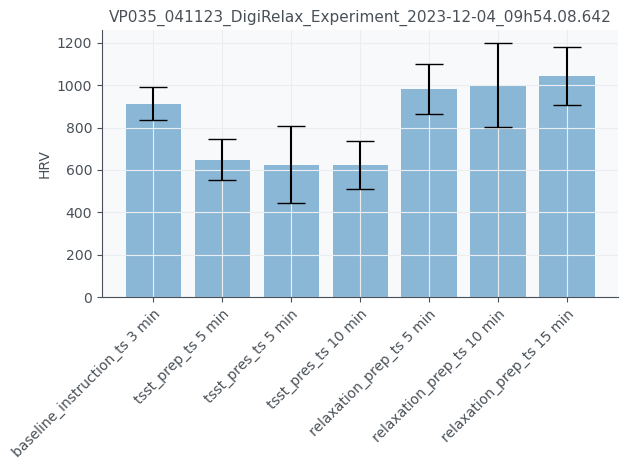

D:/Datasets/data_sony_digiRelax/study\VP037_051223\Psychopy_data\VP037_051223_DigiRelax_Experiment_2023-12-05_10h01.53.815.csv
VP037_051223_DigiRelax_Experiment_2023-12-05_10h01.53.815
baseline_instruction_ts 3 min
{'Mean RR (ms)': 845.8049466824644, 'STD RR/SDNN (ms)': 50.71969718650905, 'Mean HR (beats/min)': 71.19380651067424, 'STD HR (beats/min)': 4.2729848211505255, 'Min HR (beats/min)': 61.935483870967744, 'Max HR (beats/min)': 84.86187845303867, 'RMSSD (ms)': 61.35128325648341, 'NNxx': 114, 'pNNxx (%)': 54.02843601895734}
tsst_prep_ts 5 min
{'Mean RR (ms)': 516.8185763888889, 'STD RR/SDNN (ms)': 38.48525798489428, 'Mean HR (beats/min)': 116.66610922399188, 'STD HR (beats/min)': 7.819042371967401, 'Min HR (beats/min)': 67.66519823788546, 'Max HR (beats/min)': 153.6, 'RMSSD (ms)': 27.723010339964574, 'NNxx': 6, 'pNNxx (%)': 1.0416666666666667}
tsst_pres_ts 5 min
{'Mean RR (ms)': 484.0837722852512, 'STD RR/SDNN (ms)': 16.20810583160508, 'Mean HR (beats/min)': 124.08118782633866, 'S

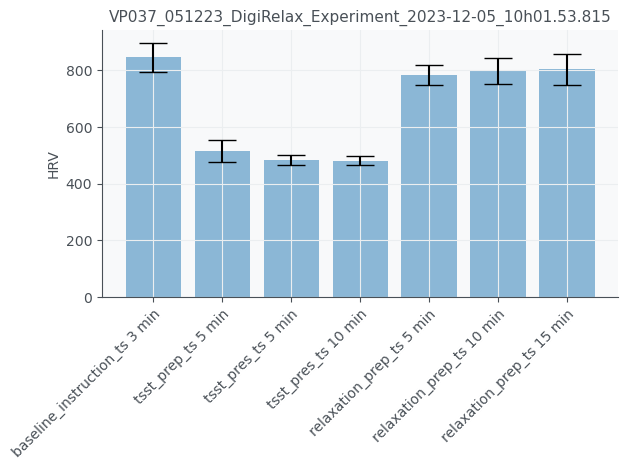

D:/Datasets/data_sony_digiRelax/study\VP038_051223\Psychopy_data\VP038_051223_DigiRelax_Experiment_2023-12-05_15h52.43.156.csv
VP038_051223_DigiRelax_Experiment_2023-12-05_15h52.43.156
baseline_instruction_ts 3 min
{'Mean RR (ms)': 838.2115610328639, 'STD RR/SDNN (ms)': 51.68093817308757, 'Mean HR (beats/min)': 71.8622139150399, 'STD HR (beats/min)': 4.589892911061064, 'Min HR (beats/min)': 61.935483870967744, 'Max HR (beats/min)': 91.97604790419162, 'RMSSD (ms)': 33.789733487311985, 'NNxx': 26, 'pNNxx (%)': 12.206572769953052}
tsst_prep_ts 5 min
{'Mean RR (ms)': 802.8078797043011, 'STD RR/SDNN (ms)': 68.43310044847011, 'Mean HR (beats/min)': 75.44435060285343, 'STD HR (beats/min)': 8.824401347024775, 'Min HR (beats/min)': 58.85057471264368, 'Max HR (beats/min)': 174.54545454545453, 'RMSSD (ms)': 74.08285722036362, 'NNxx': 52, 'pNNxx (%)': 13.978494623655914}
tsst_pres_ts 5 min
{'Mean RR (ms)': 760.6026785714286, 'STD RR/SDNN (ms)': 238.71522744987618, 'Mean HR (beats/min)': 84.7628443

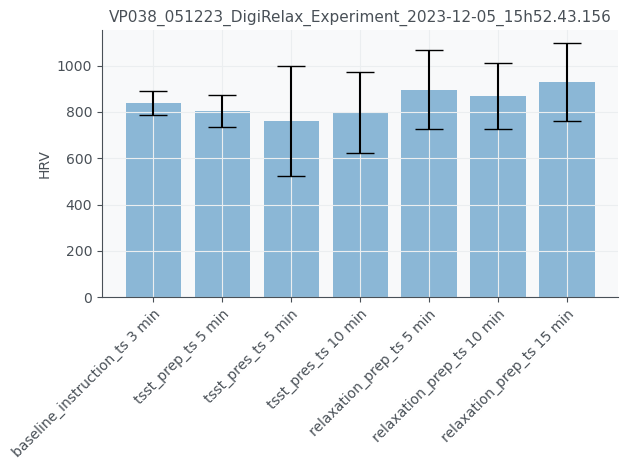

D:/Datasets/data_sony_digiRelax/study\VP039_061223\Psychopy_data\VP039_061223_DigiRelax_Experiment_2023-12-06_09h56.18.635.csv
VP039_061223_DigiRelax_Experiment_2023-12-06_09h56.18.635
baseline_instruction_ts 3 min
{'Mean RR (ms)': 902.1464646464647, 'STD RR/SDNN (ms)': 162.6774160879978, 'Mean HR (beats/min)': 67.7470560367462, 'STD HR (beats/min)': 7.118611954127862, 'Min HR (beats/min)': 32.75053304904051, 'Max HR (beats/min)': 77.57575757575758, 'RMSSD (ms)': 222.0621624489713, 'NNxx': 111, 'pNNxx (%)': 56.06060606060606}
tsst_prep_ts 5 min
{'Mean RR (ms)': 743.4312810945273, 'STD RR/SDNN (ms)': 120.23422772600078, 'Mean HR (beats/min)': 82.15255075740403, 'STD HR (beats/min)': 9.466286879071044, 'Min HR (beats/min)': 39.083969465648856, 'Max HR (beats/min)': 103.08724832214764, 'RMSSD (ms)': 147.00386505556824, 'NNxx': 68, 'pNNxx (%)': 16.915422885572138}
tsst_pres_ts 5 min
{'Mean RR (ms)': 713.4232954545455, 'STD RR/SDNN (ms)': 166.11698584665427, 'Mean HR (beats/min)': 86.791906

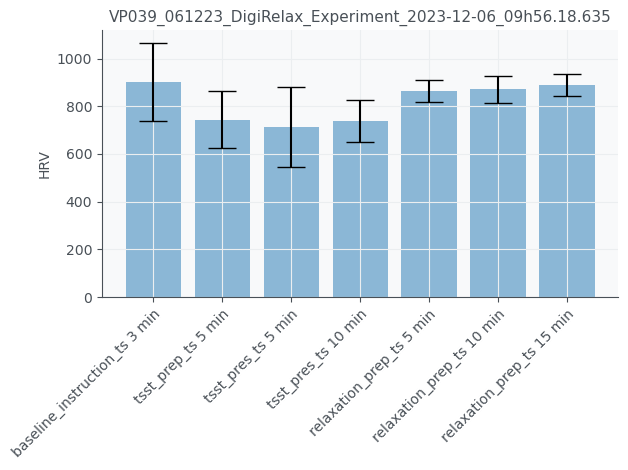

D:/Datasets/data_sony_digiRelax/study\VP040_061223\Psychopy_data\VP040_061223_DigiRelax_Experiment_2023-12-06_13h18.31.319.csv
VP040_061223_DigiRelax_Experiment_2023-12-06_13h18.31.319
baseline_instruction_ts 3 min
{'Mean RR (ms)': 881.9616336633663, 'STD RR/SDNN (ms)': 74.13647561735688, 'Mean HR (beats/min)': 68.52544486762763, 'STD HR (beats/min)': 5.924975110529424, 'Min HR (beats/min)': 56.678966789667896, 'Max HR (beats/min)': 85.81005586592178, 'RMSSD (ms)': 62.70977892810709, 'NNxx': 105, 'pNNxx (%)': 51.98019801980198}
tsst_prep_ts 5 min
{'Mean RR (ms)': 662.3177083333334, 'STD RR/SDNN (ms)': 57.89784077461652, 'Mean HR (beats/min)': 91.24915031266491, 'STD HR (beats/min)': 7.588960889966252, 'Min HR (beats/min)': 64.81012658227849, 'Max HR (beats/min)': 114.6268656716418, 'RMSSD (ms)': 38.54358490518756, 'NNxx': 51, 'pNNxx (%)': 11.333333333333334}
tsst_pres_ts 5 min
{'Mean RR (ms)': 600.6883190524194, 'STD RR/SDNN (ms)': 95.78123086917084, 'Mean HR (beats/min)': 102.00700144

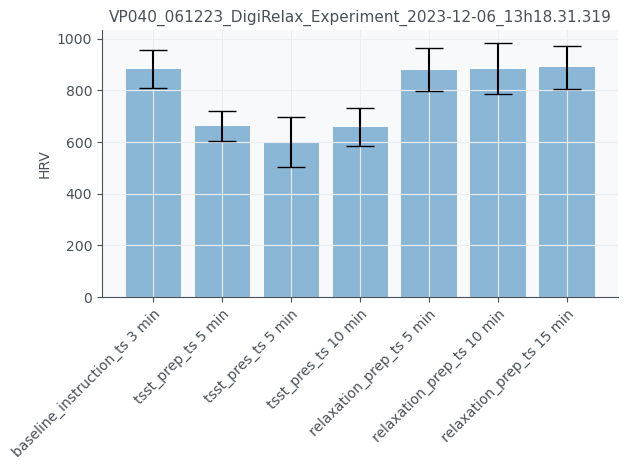

D:/Datasets/data_sony_digiRelax/study\VP041_061223\Psychopy_data\VP041_061223_DigiRelax_Experiment_2023-12-06_15h50.23.237.csv
VP041_061223_DigiRelax_Experiment_2023-12-06_15h50.23.237
baseline_instruction_ts 3 min
{'Mean RR (ms)': 930.0537109375, 'STD RR/SDNN (ms)': 77.56160405225823, 'Mean HR (beats/min)': 64.96269101875932, 'STD HR (beats/min)': 5.439965472407509, 'Min HR (beats/min)': 52.067796610169495, 'Max HR (beats/min)': 86.29213483146067, 'RMSSD (ms)': 91.94568098724795, 'NNxx': 121, 'pNNxx (%)': 63.020833333333336}
tsst_prep_ts 5 min
{'Mean RR (ms)': 659.9229120575221, 'STD RR/SDNN (ms)': 71.99238734481054, 'Mean HR (beats/min)': 91.91927164157488, 'STD HR (beats/min)': 9.33096424661917, 'Min HR (beats/min)': 58.62595419847328, 'Max HR (beats/min)': 125.90163934426229, 'RMSSD (ms)': 62.95979404324626, 'NNxx': 82, 'pNNxx (%)': 18.141592920353983}
tsst_pres_ts 5 min
{'Mean RR (ms)': 886.8233816964286, 'STD RR/SDNN (ms)': 297.43073795780333, 'Mean HR (beats/min)': 76.3998125952

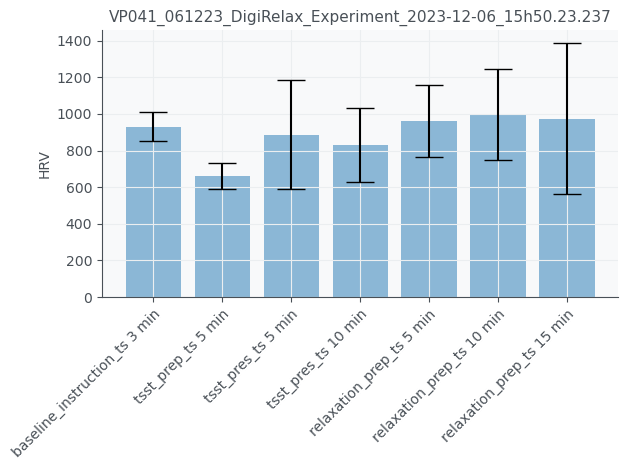

D:/Datasets/data_sony_digiRelax/study\VP042_071223\Psychopy_data\VP042_071223_DigiRelax_Experiment_2023-12-07_10h46.20.248.csv
VP042_071223_DigiRelax_Experiment_2023-12-07_10h46.20.248
baseline_instruction_ts 3 min
{'Mean RR (ms)': 802.7606502242153, 'STD RR/SDNN (ms)': 52.15245401707592, 'Mean HR (beats/min)': 75.06548397380917, 'STD HR (beats/min)': 5.008093959162222, 'Min HR (beats/min)': 64.0, 'Max HR (beats/min)': 94.81481481481481, 'RMSSD (ms)': 44.00011832106519, 'NNxx': 59, 'pNNxx (%)': 26.457399103139014}
tsst_prep_ts 5 min
{'Mean RR (ms)': 693.9802059164733, 'STD RR/SDNN (ms)': 55.40617305871493, 'Mean HR (beats/min)': 86.99428785269734, 'STD HR (beats/min)': 6.754100818248354, 'Min HR (beats/min)': 70.78341013824885, 'Max HR (beats/min)': 110.50359712230215, 'RMSSD (ms)': 34.39089385467535, 'NNxx': 62, 'pNNxx (%)': 14.385150812064966}
tsst_pres_ts 5 min
{'Mean RR (ms)': 547.297878440367, 'STD RR/SDNN (ms)': 52.20675109976588, 'Mean HR (beats/min)': 110.65511017444291, 'STD H

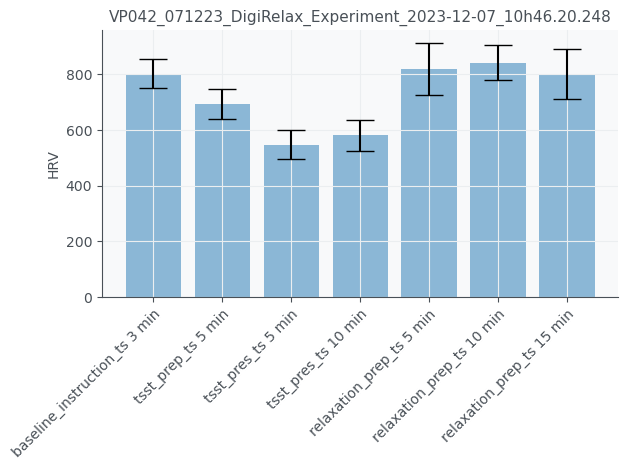

D:/Datasets/data_sony_digiRelax/study\VP043_071223\Psychopy_data\VP043_071223_DigiRelax_Experiment_2023-12-07_13h24.11.749.csv
VP043_071223_DigiRelax_Experiment_2023-12-07_13h24.11.749
baseline_instruction_ts 3 min
{'Mean RR (ms)': 724.974593495935, 'STD RR/SDNN (ms)': 114.35032816846513, 'Mean HR (beats/min)': 84.05385905918719, 'STD HR (beats/min)': 8.587631489752194, 'Min HR (beats/min)': 42.31404958677686, 'Max HR (beats/min)': 104.48979591836735, 'RMSSD (ms)': 159.1153487767865, 'NNxx': 140, 'pNNxx (%)': 56.91056910569106}
tsst_prep_ts 5 min
{'Mean RR (ms)': 803.9782350948509, 'STD RR/SDNN (ms)': 287.1760942252753, 'Mean HR (beats/min)': 81.36001475627221, 'STD HR (beats/min)': 24.656836657967045, 'Min HR (beats/min)': 25.902192242833053, 'Max HR (beats/min)': 415.13513513513516, 'RMSSD (ms)': 384.8183721396874, 'NNxx': 135, 'pNNxx (%)': 36.58536585365854}
tsst_pres_ts 5 min
{'Mean RR (ms)': 802.9338877688172, 'STD RR/SDNN (ms)': 248.56038274726205, 'Mean HR (beats/min)': 81.31183

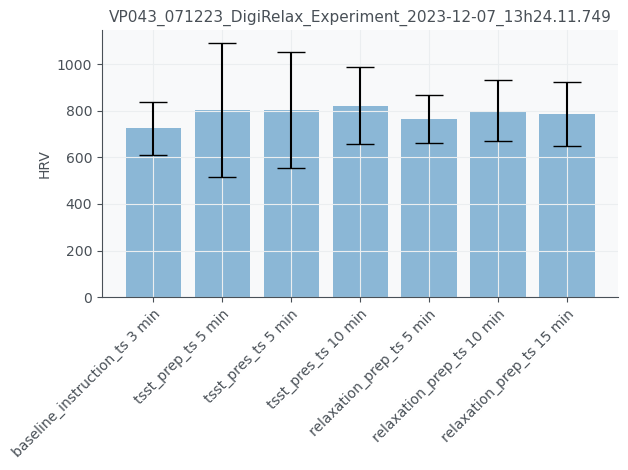

D:/Datasets/data_sony_digiRelax/study\VP044_071223\Psychopy_data\VP044_071223_DigiRelax_Experiment_2023-12-07_15h47.55.663.csv
VP044_071223_DigiRelax_Experiment_2023-12-07_15h47.55.663
baseline_instruction_ts 3 min
{'Mean RR (ms)': 817.2125860091743, 'STD RR/SDNN (ms)': 112.9333768969975, 'Mean HR (beats/min)': 74.79491755968577, 'STD HR (beats/min)': 10.018746264510897, 'Min HR (beats/min)': 56.26373626373626, 'Max HR (beats/min)': 92.53012048192771, 'RMSSD (ms)': 86.1862921781962, 'NNxx': 119, 'pNNxx (%)': 54.58715596330275}
tsst_prep_ts 5 min
{'Mean RR (ms)': 577.8227756286267, 'STD RR/SDNN (ms)': 57.33710099294007, 'Mean HR (beats/min)': 104.87128534401072, 'STD HR (beats/min)': 10.959652830800815, 'Min HR (beats/min)': 72.11267605633803, 'Max HR (beats/min)': 232.72727272727272, 'RMSSD (ms)': 29.80968741557341, 'NNxx': 32, 'pNNxx (%)': 6.189555125725338}
tsst_pres_ts 5 min
{'Mean RR (ms)': 542.2598117059891, 'STD RR/SDNN (ms)': 51.479619509442145, 'Mean HR (beats/min)': 111.600382

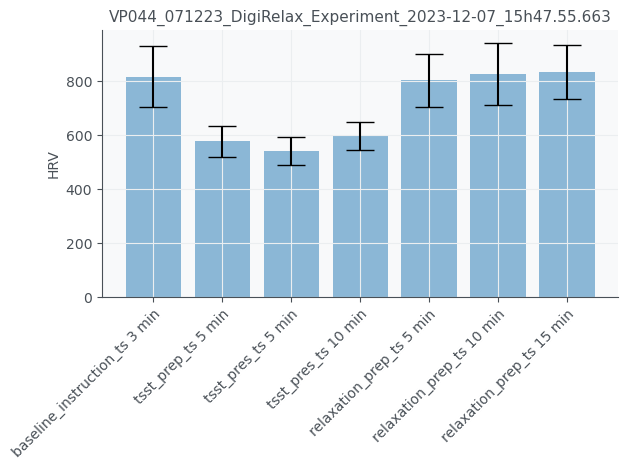

D:/Datasets/data_sony_digiRelax/study\VP045_081223\Psychopy_data\VP045_081223_DigiRelax_Experiment_2023-12-08_09h50.13.039.csv
VP045_081223_DigiRelax_Experiment_2023-12-08_09h50.13.039
baseline_instruction_ts 3 min
{'Mean RR (ms)': 907.994923857868, 'STD RR/SDNN (ms)': 64.33129803274083, 'Mean HR (beats/min)': 66.42448159150686, 'STD HR (beats/min)': 4.896426866740672, 'Min HR (beats/min)': 54.275618374558306, 'Max HR (beats/min)': 82.13903743315508, 'RMSSD (ms)': 45.655882176209744, 'NNxx': 59, 'pNNxx (%)': 29.949238578680202}
tsst_prep_ts 5 min
{'Mean RR (ms)': 767.5630623393316, 'STD RR/SDNN (ms)': 79.25289522291372, 'Mean HR (beats/min)': 78.97644633913697, 'STD HR (beats/min)': 7.936837755582035, 'Min HR (beats/min)': 47.407407407407405, 'Max HR (beats/min)': 103.78378378378379, 'RMSSD (ms)': 59.12858621118283, 'NNxx': 92, 'pNNxx (%)': 23.65038560411311}
tsst_pres_ts 5 min
{'Mean RR (ms)': 642.0866935483871, 'STD RR/SDNN (ms)': 63.28754758074545, 'Mean HR (beats/min)': 94.25081192

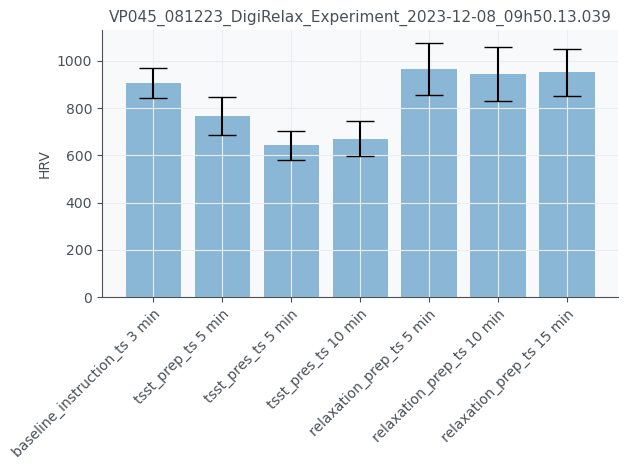

D:/Datasets/data_sony_digiRelax/study\VP046_081223\Psychopy_data\Vp046_081223_DigiRelax_Experiment_2023-12-08_14h49.59.665.csv
Vp046_081223_DigiRelax_Experiment_2023-12-08_14h49.59.665
baseline_instruction_ts 3 min
{'Mean RR (ms)': 849.0885416666666, 'STD RR/SDNN (ms)': 67.11087058545618, 'Mean HR (beats/min)': 71.12203582534607, 'STD HR (beats/min)': 5.830671060896925, 'Min HR (beats/min)': 59.766536964980546, 'Max HR (beats/min)': 93.0909090909091, 'RMSSD (ms)': 36.90889761356662, 'NNxx': 38, 'pNNxx (%)': 18.095238095238095}
tsst_prep_ts 5 min
{'Mean RR (ms)': 642.3760775862069, 'STD RR/SDNN (ms)': 104.76684996817175, 'Mean HR (beats/min)': 95.94803237939203, 'STD HR (beats/min)': 15.734528189542194, 'Min HR (beats/min)': 70.13698630136986, 'Max HR (beats/min)': 126.94214876033058, 'RMSSD (ms)': 48.3987431381734, 'NNxx': 72, 'pNNxx (%)': 15.517241379310345}
tsst_pres_ts 5 min
{'Mean RR (ms)': 451.7303328290469, 'STD RR/SDNN (ms)': 42.21668221151041, 'Mean HR (beats/min)': 133.6996182

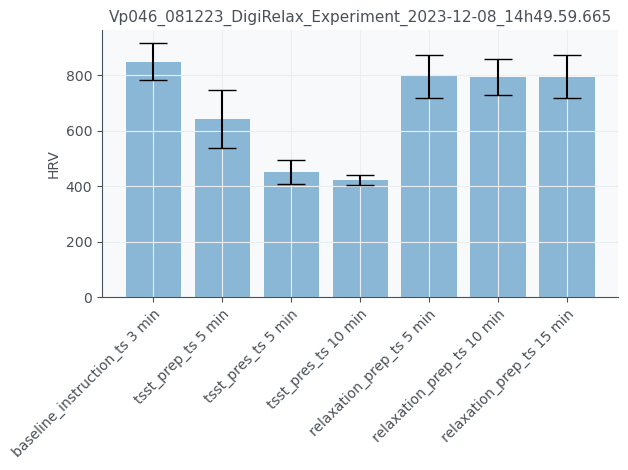

D:/Datasets/data_sony_digiRelax/study\VP047_111223\Psychopy_data\VP047_111223_DigiRelax_Experiment_2023-12-11_14h40.20.997.csv
VP047_111223_DigiRelax_Experiment_2023-12-11_14h40.20.997
baseline_instruction_ts 3 min
{'Mean RR (ms)': 858.0416165865385, 'STD RR/SDNN (ms)': 99.80022003564918, 'Mean HR (beats/min)': 70.62637182730745, 'STD HR (beats/min)': 6.303253121587495, 'Min HR (beats/min)': 38.78787878787879, 'Max HR (beats/min)': 85.81005586592178, 'RMSSD (ms)': 133.08307547584667, 'NNxx': 111, 'pNNxx (%)': 53.36538461538461}
tsst_prep_ts 5 min
{'Mean RR (ms)': 724.656780946602, 'STD RR/SDNN (ms)': 198.19801698738075, 'Mean HR (beats/min)': 88.5751726625057, 'STD HR (beats/min)': 31.617688950089676, 'Min HR (beats/min)': 38.69017632241814, 'Max HR (beats/min)': 568.8888888888889, 'RMSSD (ms)': 249.05096571373355, 'NNxx': 96, 'pNNxx (%)': 23.300970873786408}
tsst_pres_ts 5 min
{'Mean RR (ms)': 579.1545542635658, 'STD RR/SDNN (ms)': 182.3459066202384, 'Mean HR (beats/min)': 112.3364211

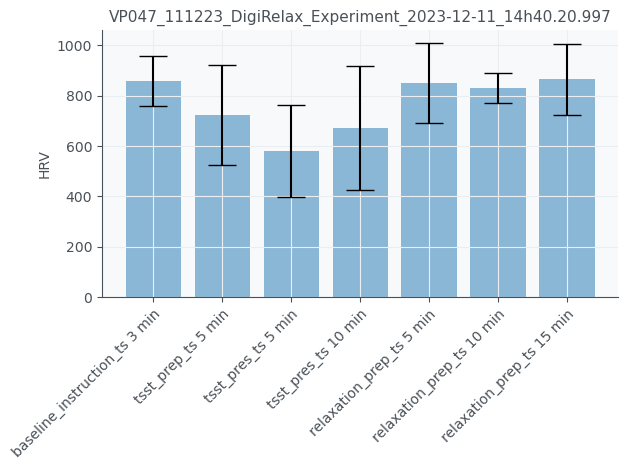

D:/Datasets/data_sony_digiRelax/study\VP048_121223\Psychopy_data\VP048_121223_DigiRelax_Experiment_2023-12-12_09h46.06.539.csv
VP048_121223_DigiRelax_Experiment_2023-12-12_09h46.06.539
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1035.7467296511627, 'STD RR/SDNN (ms)': 92.11190270106432, 'Mean HR (beats/min)': 58.43257483421456, 'STD HR (beats/min)': 5.7023898827864015, 'Min HR (beats/min)': 49.87012987012987, 'Max HR (beats/min)': 80.41884816753927, 'RMSSD (ms)': 103.33757220189504, 'NNxx': 112, 'pNNxx (%)': 65.11627906976744}
tsst_prep_ts 5 min
{'Mean RR (ms)': 875.1260080645161, 'STD RR/SDNN (ms)': 110.62156311250834, 'Mean HR (beats/min)': 69.73935013116089, 'STD HR (beats/min)': 9.422246801393332, 'Min HR (beats/min)': 52.42320819112628, 'Max HR (beats/min)': 97.21518987341773, 'RMSSD (ms)': 91.82082760092578, 'NNxx': 203, 'pNNxx (%)': 59.530791788856305}
tsst_pres_ts 5 min
{'Mean RR (ms)': 679.5188210227273, 'STD RR/SDNN (ms)': 87.20776782841644, 'Mean HR (beats/min)': 89.71329

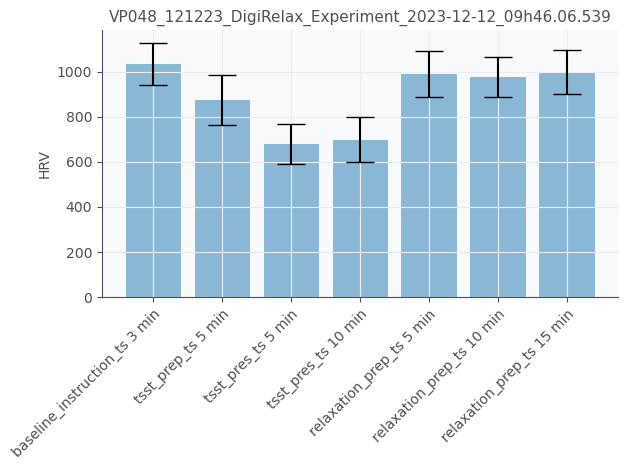

D:/Datasets/data_sony_digiRelax/study\VP049_121223\Psychopy_data\VP049_121223_DigiRelax_Experiment_2023-12-12_13h41.48.891.csv
VP049_121223_DigiRelax_Experiment_2023-12-12_13h41.48.891
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1014.0491832386364, 'STD RR/SDNN (ms)': 59.29852389459863, 'Mean HR (beats/min)': 59.38555104271366, 'STD HR (beats/min)': 3.735842002543483, 'Min HR (beats/min)': 51.37123745819398, 'Max HR (beats/min)': 77.96954314720813, 'RMSSD (ms)': 59.67601679927026, 'NNxx': 75, 'pNNxx (%)': 42.61363636363637}
tsst_prep_ts 5 min
{'Mean RR (ms)': 801.1907762096774, 'STD RR/SDNN (ms)': 96.04537311249668, 'Mean HR (beats/min)': 75.84709711329128, 'STD HR (beats/min)': 8.238352073896044, 'Min HR (beats/min)': 37.64705882352941, 'Max HR (beats/min)': 94.81481481481481, 'RMSSD (ms)': 72.06793630783373, 'NNxx': 130, 'pNNxx (%)': 34.946236559139784}
tsst_pres_ts 5 min
{'Mean RR (ms)': 593.4465263944223, 'STD RR/SDNN (ms)': 85.33551304030327, 'Mean HR (beats/min)': 102.31712203

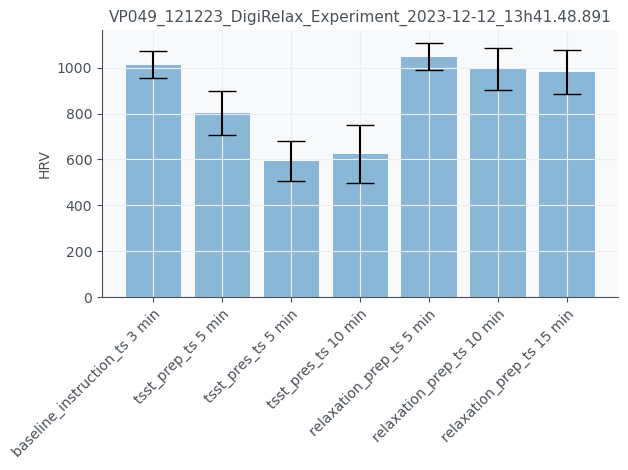

D:/Datasets/data_sony_digiRelax/study\VP050_131223\Psychopy_data\VP050_131223_DigiRelax_Experiment_2023-12-13_09h49.36.277.csv
VP050_131223_DigiRelax_Experiment_2023-12-13_09h49.36.277
baseline_instruction_ts 3 min
{'Mean RR (ms)': 660.1418357933579, 'STD RR/SDNN (ms)': 37.05262027701655, 'Mean HR (beats/min)': 91.17543207562964, 'STD HR (beats/min)': 5.112172318674527, 'Min HR (beats/min)': 79.17525773195877, 'Max HR (beats/min)': 108.16901408450704, 'RMSSD (ms)': 48.22105257068022, 'NNxx': 69, 'pNNxx (%)': 25.461254612546124}
tsst_prep_ts 5 min
{'Mean RR (ms)': 547.1831995412844, 'STD RR/SDNN (ms)': 155.9062667781892, 'Mean HR (beats/min)': 115.17499649965627, 'STD HR (beats/min)': 21.929485140532474, 'Min HR (beats/min)': 29.825242718446603, 'Max HR (beats/min)': 274.2857142857143, 'RMSSD (ms)': 178.39714809926522, 'NNxx': 116, 'pNNxx (%)': 21.28440366972477}
tsst_pres_ts 5 min
{'Mean RR (ms)': 473.69007527733754, 'STD RR/SDNN (ms)': 104.33735068361943, 'Mean HR (beats/min)': 130.86

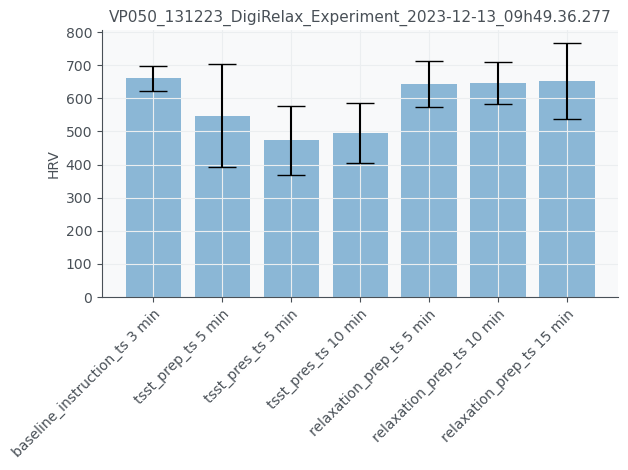

D:/Datasets/data_sony_digiRelax/study\VP051_131223\Psychopy_data\VP051_131223_DigiRelax_Experiment_2023-12-13_13h12.46.570.csv
VP051_131223_DigiRelax_Experiment_2023-12-13_13h12.46.570
baseline_instruction_ts 3 min
{'Mean RR (ms)': 990.1692708333334, 'STD RR/SDNN (ms)': 54.55942809808577, 'Mean HR (beats/min)': 60.796575344546866, 'STD HR (beats/min)': 3.658502932601648, 'Min HR (beats/min)': 55.45126353790614, 'Max HR (beats/min)': 75.66502463054188, 'RMSSD (ms)': 39.314827492806145, 'NNxx': 30, 'pNNxx (%)': 16.666666666666668}
tsst_prep_ts 5 min
{'Mean RR (ms)': 659.6809319690266, 'STD RR/SDNN (ms)': 101.65923060173492, 'Mean HR (beats/min)': 92.8731997839107, 'STD HR (beats/min)': 12.674920810754703, 'Min HR (beats/min)': 59.53488372093023, 'Max HR (beats/min)': 129.07563025210084, 'RMSSD (ms)': 35.44378443628169, 'NNxx': 52, 'pNNxx (%)': 11.504424778761061}
tsst_pres_ts 5 min
{'Mean RR (ms)': 482.22940226171244, 'STD RR/SDNN (ms)': 35.40159325488028, 'Mean HR (beats/min)': 125.0661

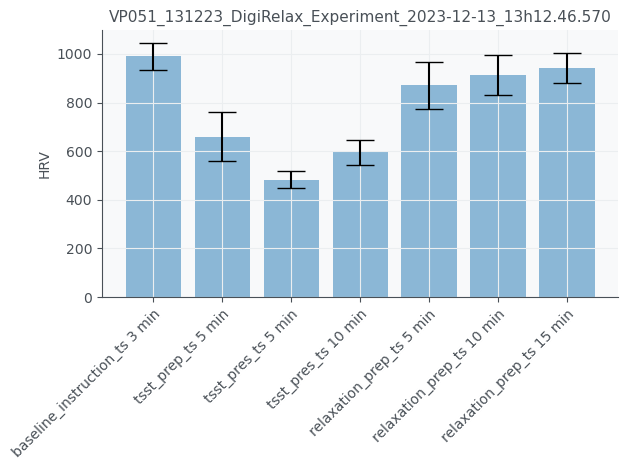

D:/Datasets/data_sony_digiRelax/study\VP052_131223\Psychopy_data\VP052_131223_DigiRelax_Experiment_2023-12-13_15h40.02.531.csv
VP052_131223_DigiRelax_Experiment_2023-12-13_15h40.02.531
baseline_instruction_ts 3 min
{'Mean RR (ms)': 870.045731707317, 'STD RR/SDNN (ms)': 75.02730895648057, 'Mean HR (beats/min)': 69.47534510557027, 'STD HR (beats/min)': 5.98603949341693, 'Min HR (beats/min)': 56.678966789667896, 'Max HR (beats/min)': 88.27586206896552, 'RMSSD (ms)': 92.95315651789683, 'NNxx': 133, 'pNNxx (%)': 64.8780487804878}
tsst_prep_ts 5 min
{'Mean RR (ms)': 756.7318369289341, 'STD RR/SDNN (ms)': 66.53292925848346, 'Mean HR (beats/min)': 79.8661729409022, 'STD HR (beats/min)': 6.614516266628807, 'Min HR (beats/min)': 58.85057471264368, 'Max HR (beats/min)': 99.74025974025975, 'RMSSD (ms)': 60.56635021369946, 'NNxx': 134, 'pNNxx (%)': 34.01015228426396}
tsst_pres_ts 5 min
{'Mean RR (ms)': 682.7554223744293, 'STD RR/SDNN (ms)': 38.01381395960033, 'Mean HR (beats/min)': 88.1443454626532

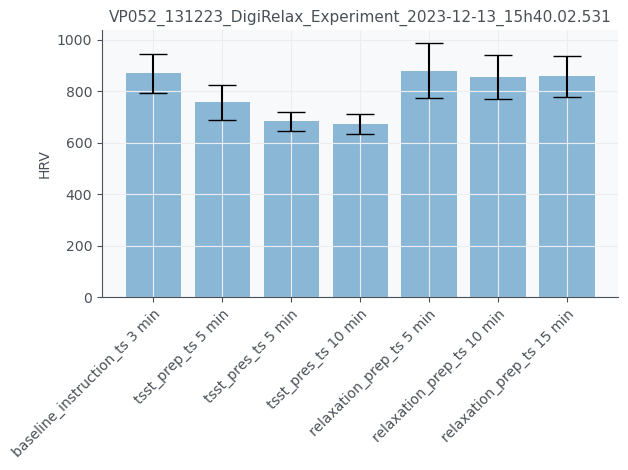

D:/Datasets/data_sony_digiRelax/study\VP053_141223\Psychopy_data\VP053_141223_DigiRelax_Experiment_2023-12-14_09h43.01.217.csv
VP053_141223_DigiRelax_Experiment_2023-12-14_09h43.01.217
baseline_instruction_ts 3 min
{'Mean RR (ms)': 938.2606907894736, 'STD RR/SDNN (ms)': 25.47634621574918, 'Mean HR (beats/min)': 63.99485157583748, 'STD HR (beats/min)': 1.7219658179352102, 'Min HR (beats/min)': 60.0, 'Max HR (beats/min)': 67.07423580786026, 'RMSSD (ms)': 9.93670418554854, 'NNxx': 1, 'pNNxx (%)': 0.5263157894736842}
tsst_prep_ts 5 min
{'Mean RR (ms)': 861.9716401734104, 'STD RR/SDNN (ms)': 54.893998578877664, 'Mean HR (beats/min)': 69.9166186147019, 'STD HR (beats/min)': 4.863808983701192, 'Min HR (beats/min)': 61.68674698795181, 'Max HR (beats/min)': 88.78612716763006, 'RMSSD (ms)': 36.95216628846442, 'NNxx': 36, 'pNNxx (%)': 10.404624277456648}
tsst_pres_ts 5 min
{'Mean RR (ms)': 705.3043735224586, 'STD RR/SDNN (ms)': 91.1130440184412, 'Mean HR (beats/min)': 86.79470759722814, 'STD HR (

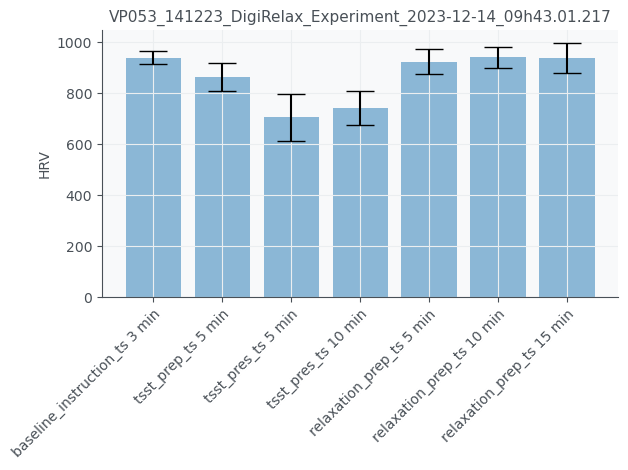

D:/Datasets/data_sony_digiRelax/study\VP054_141223\Psychopy_data\VP054_141223_DigiRelax_Experiment_2023-12-14_13h16.33.883.csv
VP054_141223_DigiRelax_Experiment_2023-12-14_13h16.33.883
baseline_instruction_ts 3 min
{'Mean RR (ms)': 883.1025680693069, 'STD RR/SDNN (ms)': 68.40653547959559, 'Mean HR (beats/min)': 68.3661827386853, 'STD HR (beats/min)': 5.517841306475237, 'Min HR (beats/min)': 55.45126353790614, 'Max HR (beats/min)': 89.82456140350877, 'RMSSD (ms)': 54.209274078026006, 'NNxx': 74, 'pNNxx (%)': 36.633663366336634}
tsst_prep_ts 5 min
{'Mean RR (ms)': 651.6799428104575, 'STD RR/SDNN (ms)': 75.38926577881796, 'Mean HR (beats/min)': 93.26967978132654, 'STD HR (beats/min)': 10.484595070952615, 'Min HR (beats/min)': 64.53781512605042, 'Max HR (beats/min)': 117.25190839694656, 'RMSSD (ms)': 32.78584642148414, 'NNxx': 49, 'pNNxx (%)': 10.675381263616558}
tsst_pres_ts 5 min
{'Mean RR (ms)': 571.2162404397706, 'STD RR/SDNN (ms)': 53.16917071577437, 'Mean HR (beats/min)': 105.8584086

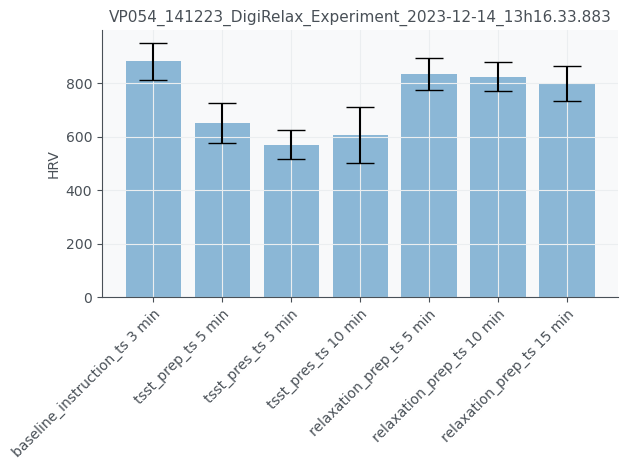

D:/Datasets/data_sony_digiRelax/study\VP055_141223\Psychopy_data\VP055_141223_DigiRelax_Experiment_2023-12-14_15h45.35.483.csv
VP055_141223_DigiRelax_Experiment_2023-12-14_15h45.35.483
baseline_instruction_ts 3 min
{'Mean RR (ms)': 930.2978515625, 'STD RR/SDNN (ms)': 72.48924641495036, 'Mean HR (beats/min)': 64.89332756884495, 'STD HR (beats/min)': 5.138655848766828, 'Min HR (beats/min)': 54.08450704225352, 'Max HR (beats/min)': 83.93442622950819, 'RMSSD (ms)': 83.76733167591497, 'NNxx': 102, 'pNNxx (%)': 53.125}
tsst_prep_ts 5 min
{'Mean RR (ms)': 649.9268110021786, 'STD RR/SDNN (ms)': 59.994069187110604, 'Mean HR (beats/min)': 93.05511994825231, 'STD HR (beats/min)': 8.092431792807563, 'Min HR (beats/min)': 56.470588235294116, 'Max HR (beats/min)': 116.36363636363636, 'RMSSD (ms)': 38.03270382892, 'NNxx': 32, 'pNNxx (%)': 6.971677559912854}
tsst_pres_ts 5 min
{'Mean RR (ms)': 479.4091091492777, 'STD RR/SDNN (ms)': 50.680867303727446, 'Mean HR (beats/min)': 126.93797309686369, 'STD HR

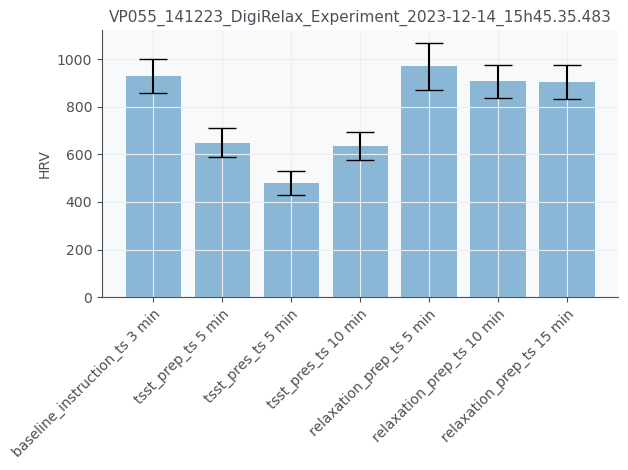

D:/Datasets/data_sony_digiRelax/study\VP056_151223\Psychopy_data\VP056_151223_DigiRelax_Experiment_2023-12-15_09h45.05.317.csv
VP056_151223_DigiRelax_Experiment_2023-12-15_09h45.05.317
baseline_instruction_ts 3 min
{'Mean RR (ms)': 827.4377893518518, 'STD RR/SDNN (ms)': 50.190284347953515, 'Mean HR (beats/min)': 72.77203284640352, 'STD HR (beats/min)': 4.286037395006568, 'Min HR (beats/min)': 59.07692307692308, 'Max HR (beats/min)': 81.70212765957447, 'RMSSD (ms)': 45.62358755578912, 'NNxx': 70, 'pNNxx (%)': 32.407407407407405}
tsst_prep_ts 5 min
{'Mean RR (ms)': 713.2831190191388, 'STD RR/SDNN (ms)': 95.51141190013232, 'Mean HR (beats/min)': 86.37957781666906, 'STD HR (beats/min)': 20.15871619858475, 'Min HR (beats/min)': 48.45425867507886, 'Max HR (beats/min)': 365.7142857142857, 'RMSSD (ms)': 101.30492725860131, 'NNxx': 131, 'pNNxx (%)': 31.339712918660286}
tsst_pres_ts 5 min
{'Mean RR (ms)': 657.3771338105727, 'STD RR/SDNN (ms)': 70.07529673471835, 'Mean HR (beats/min)': 92.3003346

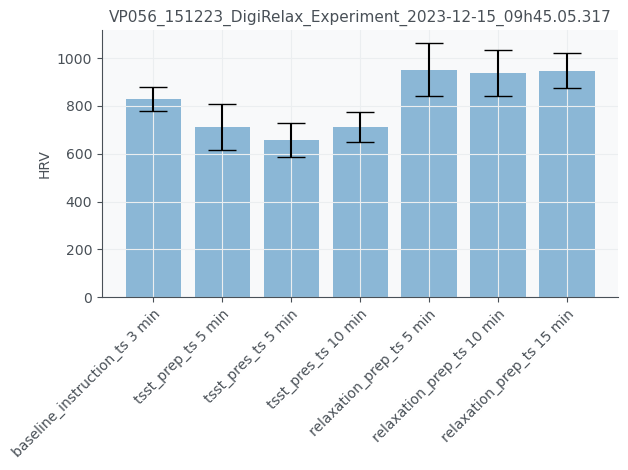

D:/Datasets/data_sony_digiRelax/study\VP057_151223\Psychopy_data\VP057_151223_DigiRelax_Experiment_2023-12-15_15h00.46.722.csv
VP057_151223_DigiRelax_Experiment_2023-12-15_15h00.46.722
baseline_instruction_ts 3 min
{'Mean RR (ms)': 888.3203125, 'STD RR/SDNN (ms)': 86.62737126703499, 'Mean HR (beats/min)': 68.17170960477944, 'STD HR (beats/min)': 6.554721219946961, 'Min HR (beats/min)': 46.68693009118541, 'Max HR (beats/min)': 99.74025974025975, 'RMSSD (ms)': 83.42983977244046, 'NNxx': 108, 'pNNxx (%)': 54.0}
tsst_prep_ts 5 min
{'Mean RR (ms)': 865.0588768115942, 'STD RR/SDNN (ms)': 333.91413547196026, 'Mean HR (beats/min)': 78.94458952237012, 'STD HR (beats/min)': 58.7771437924297, 'Min HR (beats/min)': 14.78344562078922, 'Max HR (beats/min)': 808.421052631579, 'RMSSD (ms)': 472.91664811621416, 'NNxx': 184, 'pNNxx (%)': 53.333333333333336}
tsst_pres_ts 5 min
{'Mean RR (ms)': 717.9028614457832, 'STD RR/SDNN (ms)': 195.89751260191989, 'Mean HR (beats/min)': 133.5486694621461, 'STD HR (be

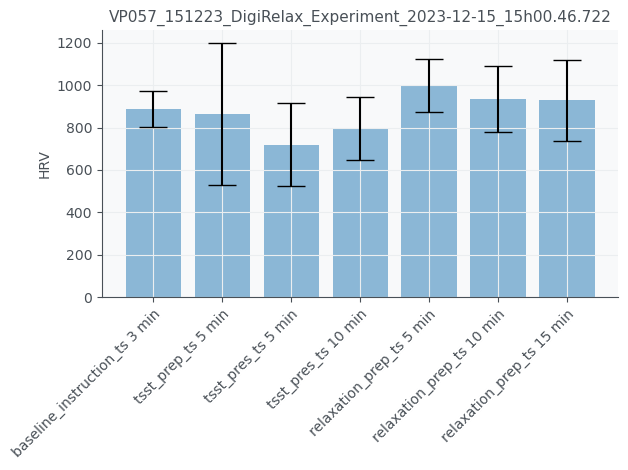

D:/Datasets/data_sony_digiRelax/study\VP059_181223\Psychopy_data\VP059_181223_DigiRelax_Experiment_2023-12-18_14h46.34.198.csv
VP059_181223_DigiRelax_Experiment_2023-12-18_14h46.34.198
baseline_instruction_ts 3 min
{'Mean RR (ms)': 682.8930104961833, 'STD RR/SDNN (ms)': 30.08837459654093, 'Mean HR (beats/min)': 88.03322142590237, 'STD HR (beats/min)': 3.908996165770308, 'Min HR (beats/min)': 77.57575757575758, 'Max HR (beats/min)': 103.78378378378379, 'RMSSD (ms)': 21.38174557751473, 'NNxx': 3, 'pNNxx (%)': 1.1450381679389312}
tsst_prep_ts 5 min
{'Mean RR (ms)': 640.7004425965665, 'STD RR/SDNN (ms)': 48.722164461768834, 'Mean HR (beats/min)': 94.1908216689695, 'STD HR (beats/min)': 7.575765624807418, 'Min HR (beats/min)': 52.067796610169495, 'Max HR (beats/min)': 174.54545454545453, 'RMSSD (ms)': 57.64748909893615, 'NNxx': 23, 'pNNxx (%)': 4.935622317596566}
tsst_pres_ts 5 min
{'Mean RR (ms)': 622.7247520876826, 'STD RR/SDNN (ms)': 45.634132660343084, 'Mean HR (beats/min)': 96.86654495

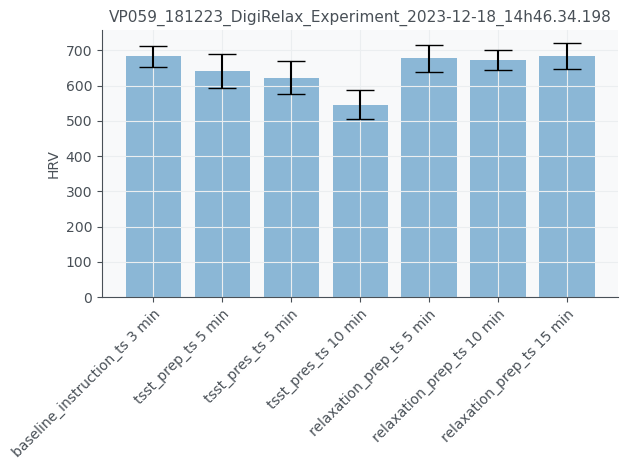

D:/Datasets/data_sony_digiRelax/study\VP060_191223\Psychopy_data\VP060_191223_DigiRelax_Experiment_2023-12-19_09h48.26.679.csv
VP060_191223_DigiRelax_Experiment_2023-12-19_09h48.26.679
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1087.938262195122, 'STD RR/SDNN (ms)': 109.7185437637877, 'Mean HR (beats/min)': 55.776817729708924, 'STD HR (beats/min)': 6.280493471795337, 'Min HR (beats/min)': 45.98802395209581, 'Max HR (beats/min)': 77.1859296482412, 'RMSSD (ms)': 128.3075571250382, 'NNxx': 115, 'pNNxx (%)': 70.1219512195122}
tsst_prep_ts 5 min
{'Mean RR (ms)': 807.4398712737127, 'STD RR/SDNN (ms)': 125.44692486264974, 'Mean HR (beats/min)': 76.1460444988356, 'STD HR (beats/min)': 12.077618223430228, 'Min HR (beats/min)': 50.86092715231788, 'Max HR (beats/min)': 114.6268656716418, 'RMSSD (ms)': 75.74390293018406, 'NNxx': 141, 'pNNxx (%)': 38.21138211382114}
tsst_pres_ts 5 min
{'Mean RR (ms)': 573.9483173076923, 'STD RR/SDNN (ms)': 79.31809596320781, 'Mean HR (beats/min)': 106.183382256

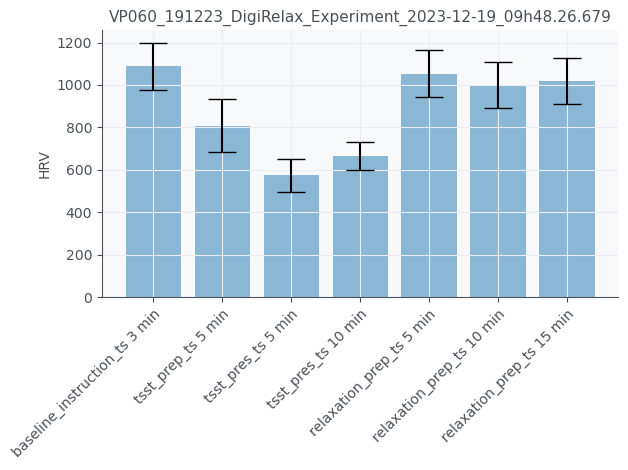

D:/Datasets/data_sony_digiRelax/study\VP063_040124\Psychopy_data\VP063_040124_DigiRelax_Experiment_2024-01-04_14h59.12.423.csv
VP063_040124_DigiRelax_Experiment_2024-01-04_14h59.12.423
baseline_instruction_ts 3 min
{'Mean RR (ms)': 789.4081858407079, 'STD RR/SDNN (ms)': 52.25187564830901, 'Mean HR (beats/min)': 76.2522720545265, 'STD HR (beats/min)': 3.859742434284679, 'Min HR (beats/min)': 43.02521008403362, 'Max HR (beats/min)': 84.3956043956044, 'RMSSD (ms)': 67.24753051408695, 'NNxx': 18, 'pNNxx (%)': 7.964601769911504}
tsst_prep_ts 5 min
{'Mean RR (ms)': 713.4606758373205, 'STD RR/SDNN (ms)': 49.9161443600905, 'Mean HR (beats/min)': 84.42762086729287, 'STD HR (beats/min)': 4.946621656713712, 'Min HR (beats/min)': 43.51274787535411, 'Max HR (beats/min)': 105.20547945205479, 'RMSSD (ms)': 53.19269220687535, 'NNxx': 20, 'pNNxx (%)': 4.784688995215311}
tsst_pres_ts 5 min
{'Mean RR (ms)': 651.8479896061269, 'STD RR/SDNN (ms)': 94.03424648541124, 'Mean HR (beats/min)': 93.36452716514844

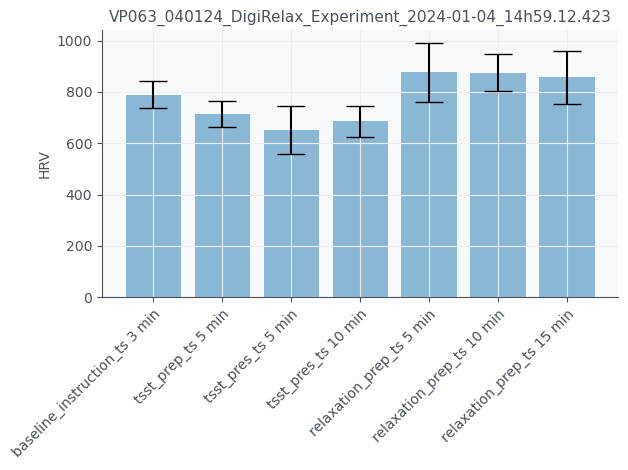

D:/Datasets/data_sony_digiRelax/study\VP064_050124\Psychopy_data\VP064_050124_DigiRelax_Experiment_2024-01-05_09h44.11.070.csv
VP064_050124_DigiRelax_Experiment_2024-01-05_09h44.11.070
baseline_instruction_ts 3 min
{'Mean RR (ms)': 916.8269230769231, 'STD RR/SDNN (ms)': 46.75661002722153, 'Mean HR (beats/min)': 65.61328185254214, 'STD HR (beats/min)': 3.3455832418371187, 'Min HR (beats/min)': 57.744360902255636, 'Max HR (beats/min)': 75.29411764705883, 'RMSSD (ms)': 45.35011658484486, 'NNxx': 56, 'pNNxx (%)': 28.71794871794872}
tsst_prep_ts 5 min
{'Mean RR (ms)': 564.6124881404174, 'STD RR/SDNN (ms)': 56.32154254329419, 'Mean HR (beats/min)': 107.17694231849657, 'STD HR (beats/min)': 9.507700994050541, 'Min HR (beats/min)': 56.470588235294116, 'Max HR (beats/min)': 182.85714285714286, 'RMSSD (ms)': 38.41173105072786, 'NNxx': 8, 'pNNxx (%)': 1.5180265654648957}
tsst_pres_ts 5 min
{'Mean RR (ms)': 644.2528347732182, 'STD RR/SDNN (ms)': 104.74533419279642, 'Mean HR (beats/min)': 94.954320

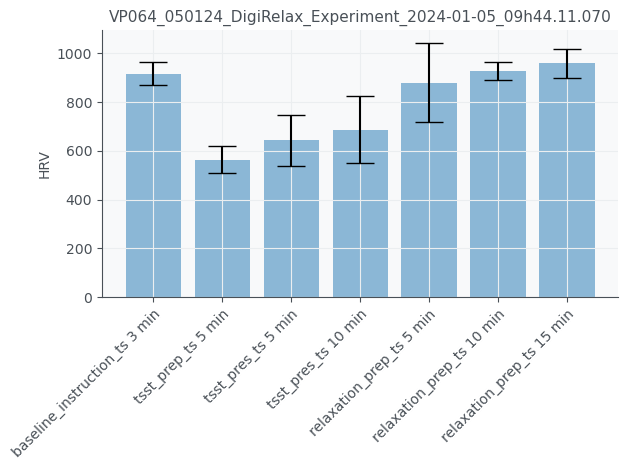

D:/Datasets/data_sony_digiRelax/study\VP065_050124\Psychopy_data\VP065_050124_DigiRelax_Experiment_2024-01-05_14h41.28.548.csv
VP065_050124_DigiRelax_Experiment_2024-01-05_14h41.28.548
baseline_instruction_ts 3 min
{'Mean RR (ms)': 926.3479598445596, 'STD RR/SDNN (ms)': 53.81598912031085, 'Mean HR (beats/min)': 65.01899558688876, 'STD HR (beats/min)': 4.311777443435664, 'Min HR (beats/min)': 58.18181818181818, 'Max HR (beats/min)': 87.27272727272727, 'RMSSD (ms)': 47.04845971164845, 'NNxx': 47, 'pNNxx (%)': 24.352331606217618}
tsst_prep_ts 5 min
{'Mean RR (ms)': 943.4025039432177, 'STD RR/SDNN (ms)': 956.3789435082092, 'Mean HR (beats/min)': 101.45569048473226, 'STD HR (beats/min)': 180.20178630893713, 'Min HR (beats/min)': 4.240750966316952, 'Max HR (beats/min)': 3072.0, 'RMSSD (ms)': 1131.927621508771, 'NNxx': 229, 'pNNxx (%)': 72.2397476340694}
tsst_pres_ts 5 min
{'Mean RR (ms)': 597.7427062374245, 'STD RR/SDNN (ms)': 458.65617568839394, 'Mean HR (beats/min)': 116.9105144135124, 'ST

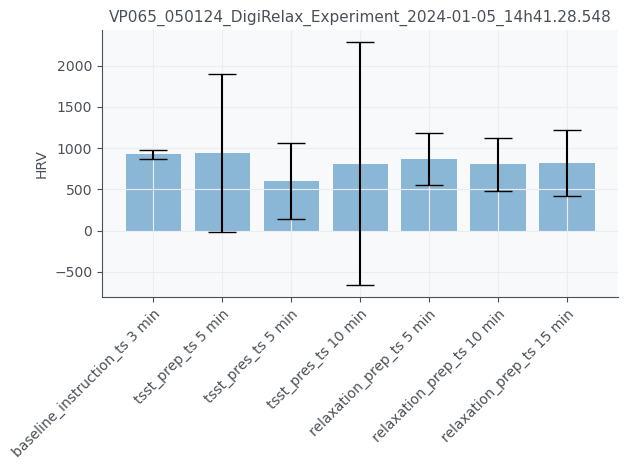

D:/Datasets/data_sony_digiRelax/study\VP066_080124\Psychopy_data\VP066_080124_DigiRelax_Experiment_2024-01-08_13h36.32.476.csv
VP066_080124_DigiRelax_Experiment_2024-01-08_13h36.32.476
baseline_instruction_ts 3 min
{'Mean RR (ms)': 778.1966430131005, 'STD RR/SDNN (ms)': 98.08043890984499, 'Mean HR (beats/min)': 78.4732050088242, 'STD HR (beats/min)': 11.688788295785795, 'Min HR (beats/min)': 54.275618374558306, 'Max HR (beats/min)': 155.15151515151516, 'RMSSD (ms)': 131.90134271432194, 'NNxx': 90, 'pNNxx (%)': 39.301310043668124}
tsst_prep_ts 5 min
{'Mean RR (ms)': 632.6966366525423, 'STD RR/SDNN (ms)': 82.93068075381657, 'Mean HR (beats/min)': 96.58747274888518, 'STD HR (beats/min)': 14.090356885580977, 'Min HR (beats/min)': 52.244897959183675, 'Max HR (beats/min)': 182.85714285714286, 'RMSSD (ms)': 75.21987939933466, 'NNxx': 88, 'pNNxx (%)': 18.64406779661017}
tsst_pres_ts 5 min
{'Mean RR (ms)': 579.8998786407767, 'STD RR/SDNN (ms)': 82.18905981566726, 'Mean HR (beats/min)': 105.7293

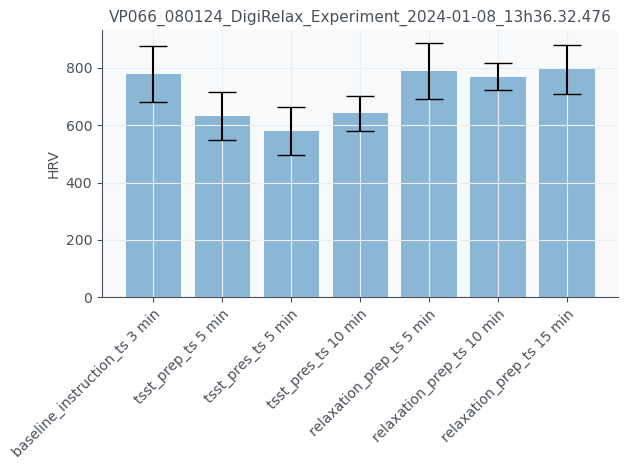

D:/Datasets/data_sony_digiRelax/study\VP067_100124\Psychopy_data\VP067_100124_DigiRelax_Experiment_2024-01-10_09h51.01.071.csv
VP067_100124_DigiRelax_Experiment_2024-01-10_09h51.01.071
baseline_instruction_ts 3 min
{'Mean RR (ms)': 787.4793502202643, 'STD RR/SDNN (ms)': 34.69599146974222, 'Mean HR (beats/min)': 76.33725659094736, 'STD HR (beats/min)': 3.2915807659900675, 'Min HR (beats/min)': 67.07423580786026, 'Max HR (beats/min)': 84.3956043956044, 'RMSSD (ms)': 24.15113536521476, 'NNxx': 4, 'pNNxx (%)': 1.7621145374449338}
tsst_prep_ts 5 min
{'Mean RR (ms)': 653.0090065502184, 'STD RR/SDNN (ms)': 66.35021540874455, 'Mean HR (beats/min)': 92.8932043050826, 'STD HR (beats/min)': 10.11431122529118, 'Min HR (beats/min)': 70.13698630136986, 'Max HR (beats/min)': 155.15151515151516, 'RMSSD (ms)': 33.475904568246335, 'NNxx': 23, 'pNNxx (%)': 5.021834061135372}
tsst_pres_ts 5 min
{'Mean RR (ms)': 628.9802631578947, 'STD RR/SDNN (ms)': 58.22301283808582, 'Mean HR (beats/min)': 96.44427701130

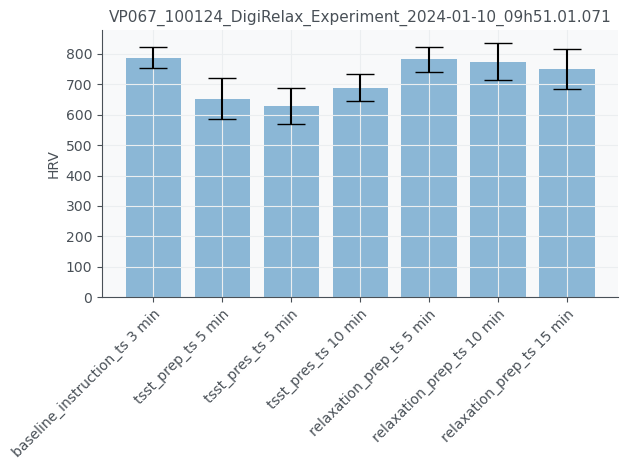

D:/Datasets/data_sony_digiRelax/study\VP068_100124\Psychopy_data\VP068_100124_DigiRelax_Experiment_2024-01-10_14h41.55.244.csv
VP068_100124_DigiRelax_Experiment_2024-01-10_14h41.55.244
baseline_instruction_ts 3 min
{'Mean RR (ms)': 939.5764802631579, 'STD RR/SDNN (ms)': 113.73594040347045, 'Mean HR (beats/min)': 64.78292825336882, 'STD HR (beats/min)': 7.773534014079303, 'Min HR (beats/min)': 40.10443864229765, 'Max HR (beats/min)': 84.3956043956044, 'RMSSD (ms)': 110.65957494567625, 'NNxx': 104, 'pNNxx (%)': 54.73684210526316}
tsst_prep_ts 5 min
{'Mean RR (ms)': 745.654296875, 'STD RR/SDNN (ms)': 88.25919626965663, 'Mean HR (beats/min)': 81.57463661460274, 'STD HR (beats/min)': 9.476842033993336, 'Min HR (beats/min)': 51.37123745819398, 'Max HR (beats/min)': 102.4, 'RMSSD (ms)': 50.906484168562805, 'NNxx': 95, 'pNNxx (%)': 23.75}
tsst_pres_ts 5 min
{'Mean RR (ms)': 546.5250799817185, 'STD RR/SDNN (ms)': 81.8163254322786, 'Mean HR (beats/min)': 112.09750462998937, 'STD HR (beats/min)':

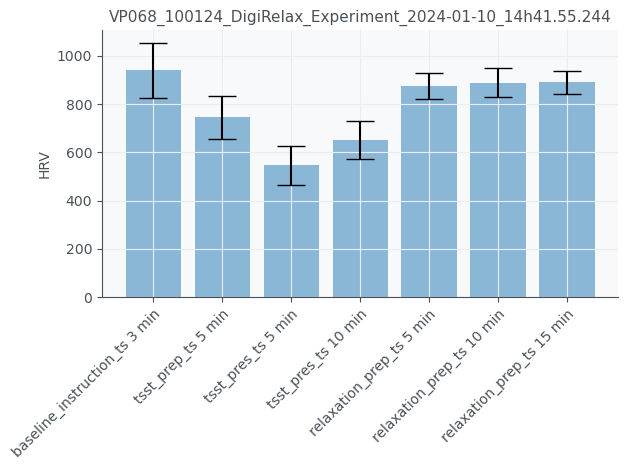

D:/Datasets/data_sony_digiRelax/study\VP069_110124\Psychopy_data\VP069_110124_DigiRelax_Experiment_2024-01-11_09h51.14.639.csv
VP069_110124_DigiRelax_Experiment_2024-01-11_09h51.14.639
baseline_instruction_ts 3 min
{'Mean RR (ms)': 829.0879360465116, 'STD RR/SDNN (ms)': 58.724983175596634, 'Mean HR (beats/min)': 72.72418634382157, 'STD HR (beats/min)': 5.0469342614152986, 'Min HR (beats/min)': 58.18181818181818, 'Max HR (beats/min)': 89.30232558139535, 'RMSSD (ms)': 45.637193212100826, 'NNxx': 62, 'pNNxx (%)': 28.837209302325583}
tsst_prep_ts 5 min
{'Mean RR (ms)': 612.4087474385246, 'STD RR/SDNN (ms)': 55.87715407411609, 'Mean HR (beats/min)': 98.86639025878289, 'STD HR (beats/min)': 10.222568208694483, 'Min HR (beats/min)': 74.92682926829268, 'Max HR (beats/min)': 199.4805194805195, 'RMSSD (ms)': 43.39611534109077, 'NNxx': 34, 'pNNxx (%)': 6.967213114754099}
tsst_pres_ts 5 min
{'Mean RR (ms)': 719.0512048192771, 'STD RR/SDNN (ms)': 80.45141526912025, 'Mean HR (beats/min)': 84.8587087

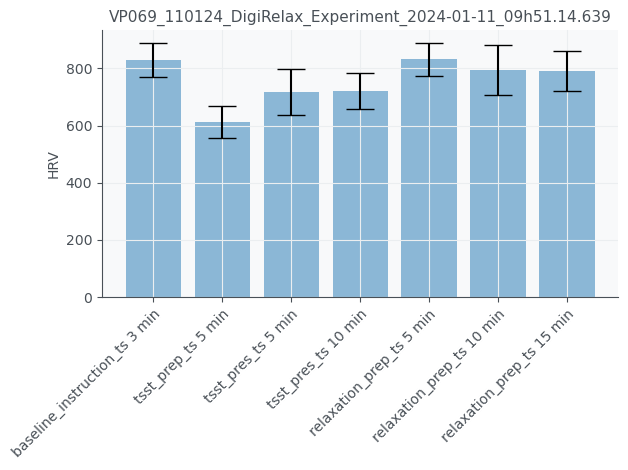

D:/Datasets/data_sony_digiRelax/study\VP070_110124\Psychopy_data\VP070_110124_DigiRelax_Experiment_2024-01-11_14h48.50.074.csv
VP070_110124_DigiRelax_Experiment_2024-01-11_14h48.50.074
baseline_instruction_ts 3 min
{'Mean RR (ms)': 881.7489170792079, 'STD RR/SDNN (ms)': 46.003153791359544, 'Mean HR (beats/min)': 68.24695422207465, 'STD HR (beats/min)': 3.865135534450298, 'Min HR (beats/min)': 61.44, 'Max HR (beats/min)': 86.29213483146067, 'RMSSD (ms)': 32.896191169531704, 'NNxx': 31, 'pNNxx (%)': 15.346534653465346}
tsst_prep_ts 5 min
{'Mean RR (ms)': 696.4324737762238, 'STD RR/SDNN (ms)': 119.57071458094482, 'Mean HR (beats/min)': 88.0242398654073, 'STD HR (beats/min)': 13.005720241210108, 'Min HR (beats/min)': 37.73955773955774, 'Max HR (beats/min)': 247.74193548387098, 'RMSSD (ms)': 102.05432926787934, 'NNxx': 64, 'pNNxx (%)': 14.918414918414918}
tsst_pres_ts 5 min
{'Mean RR (ms)': 672.5964245495495, 'STD RR/SDNN (ms)': 63.748606520092636, 'Mean HR (beats/min)': 90.01148991201757, 

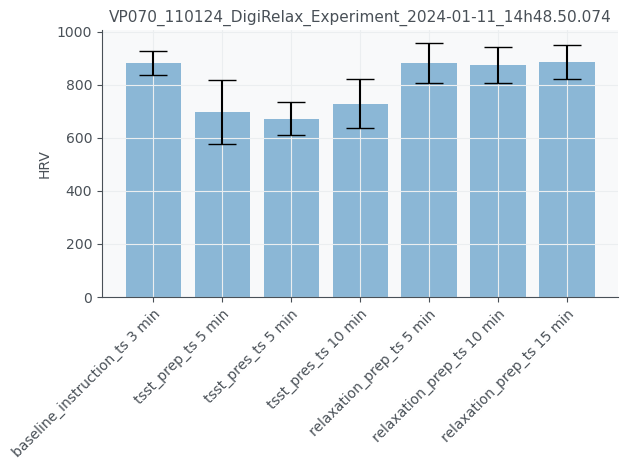

D:/Datasets/data_sony_digiRelax/study\VP071_120124\Psychopy_data\VP071_120124_DigiRelax_Experiment_2024-01-12_09h48.13.466.csv
VP071_120124_DigiRelax_Experiment_2024-01-12_09h48.13.466
baseline_instruction_ts 3 min
{'Mean RR (ms)': 868.0218446601941, 'STD RR/SDNN (ms)': 60.2040321887859, 'Mean HR (beats/min)': 69.46490803502905, 'STD HR (beats/min)': 4.955688479795921, 'Min HR (beats/min)': 60.0, 'Max HR (beats/min)': 87.27272727272727, 'RMSSD (ms)': 58.718743712599775, 'NNxx': 101, 'pNNxx (%)': 49.029126213592235}
tsst_prep_ts 5 min
{'Mean RR (ms)': 932.18994140625, 'STD RR/SDNN (ms)': 3569.5192331198223, 'Mean HR (beats/min)': 88.93084685133027, 'STD HR (beats/min)': 59.401958234793746, 'Min HR (beats/min)': 0.9282649422856107, 'Max HR (beats/min)': 768.0, 'RMSSD (ms)': 5063.28355338515, 'NNxx': 78, 'pNNxx (%)': 24.375}
tsst_pres_ts 5 min
{'Mean RR (ms)': 568.9657738095239, 'STD RR/SDNN (ms)': 114.32371301033601, 'Mean HR (beats/min)': 109.2135512240327, 'STD HR (beats/min)': 27.0665

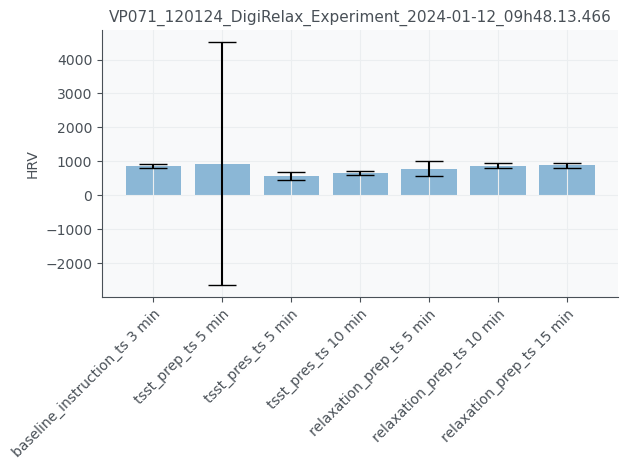

D:/Datasets/data_sony_digiRelax/study\VP072_120124\Psychopy_data\VP072_120124_DigiRelax_Experiment_2024-01-12_14h45.23.547.csv
VP072_120124_DigiRelax_Experiment_2024-01-12_14h45.23.547
baseline_instruction_ts 3 min
{'Mean RR (ms)': 948.0698529411765, 'STD RR/SDNN (ms)': 57.58930701018665, 'Mean HR (beats/min)': 63.52690273308054, 'STD HR (beats/min)': 3.978111274821187, 'Min HR (beats/min)': 52.42320819112628, 'Max HR (beats/min)': 78.36734693877551, 'RMSSD (ms)': 59.85084616922621, 'NNxx': 78, 'pNNxx (%)': 41.711229946524064}
tsst_prep_ts 5 min
{'Mean RR (ms)': 673.9824351015801, 'STD RR/SDNN (ms)': 88.49039943613487, 'Mean HR (beats/min)': 90.60144208706501, 'STD HR (beats/min)': 12.161954243483178, 'Min HR (beats/min)': 63.47107438016529, 'Max HR (beats/min)': 130.16949152542372, 'RMSSD (ms)': 49.53131244910918, 'NNxx': 110, 'pNNxx (%)': 24.830699774266364}
tsst_pres_ts 5 min
{'Mean RR (ms)': 724.9127730582525, 'STD RR/SDNN (ms)': 103.82027681891356, 'Mean HR (beats/min)': 84.607280

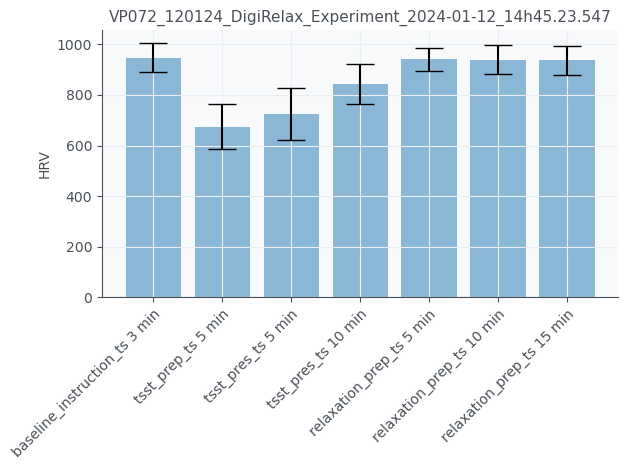

In [18]:
for sub_dir in sub_dirs:
    
    sub_dir_path= os.path.join(data_dir_path, sub_dir)
    psychopy_file_path = os.path.join(sub_dir_path, "Psychopy_data")
    psychopy_file_path = glob.glob(psychopy_file_path+ "/*.csv")[0]
    print(psychopy_file_path)
    
    psychopy_df = read_manipulate_psychopy(psychopy_file_path)
    
    shimmer_files_subdir = os.path.join(sub_dir_path, "Shimmer_data")
    shimmer_files_subdir_subdir_name = next(os.walk(shimmer_files_subdir))[1][0]
    shimmer_files_parent_path = os.path.join(shimmer_files_subdir, shimmer_files_subdir_subdir_name)
    shimmer_files_name = glob.glob(shimmer_files_parent_path+ "/*.csv")
    
    #print(shimmer_files_name)
    
    for sh_file in shimmer_files_name:
        
        if '_6B1E_' in sh_file:
            hr_shimmer_path = sh_file
            
    fol_path, file_name=os.path.split(psychopy_file_path)
    sub_id=file_name[:-4]
    print(sub_id)
    
    ## heart rate
    timestamp_hr_col = "Shimmer_6B1E_Timestamp_Unix_CAL"
    ecg_col_name = "Shimmer_6B1E_ECG_LL-LA_24BIT_CAL"
    
    hr_df=read_shimmer_sensor(hr_shimmer_path)
    hr_df = standardize_timestamps_shimmer(hr_df, timestamp_hr_col)
    
    selected_ecg_df = hr_df[[timestamp_hr_col, ecg_col_name]]
    selected_ecg_df = selected_ecg_df.copy()
    selected_ecg_df['heartrate'] = selected_ecg_df[ecg_col_name]
    selected_ecg_df=col_from_str_float(selected_ecg_df, "heartrate")
    
    mean_hrv_list,std_hrv_list, event_interets_plot, all_rr_one_list, all_rr_sublist =  get_mean_std_event_list(psychopy_df, selected_ecg_df, event_interest_list_new, offset_min_list_new, timestamp_hr_col, "heartrate")
    
    
    title_figure = "HRV"
    y_label_fig = "HRV"
    plot_mean_std(mean_hrv_list, std_hrv_list, event_interets_plot, sub_id, y_label_fig)
    
    
    
    #norm_mean_hrv, norm_std_hrv = min_max_norm(all_rr_one_list, all_rr_sublist)
    
    #export_dict= {"subject_id":sub_id , 'event_interst': event_interets_plot, "mean_hrv":mean_hrv_list , "std_hrv": std_hrv_list , "norm_mean_hrv":norm_mean_hrv,  "norm_std_hrv": norm_std_hrv}
    
     
    #dest_path_csv = os.path.join(comp_dest_path,file_name)
    #df_export = pd.DataFrame.from_dict(export_dict)
    #df_export.to_csv(dest_path_csv)

['baseline_instruction_ts 3 min',
 'tsst_prep_ts 5 min',
 'tsst_pres_ts 5 min',
 'tsst_pres_ts 10 min',
 'relaxation_prep_ts 5 min',
 'relaxation_prep_ts 10 min',
 'relaxation_prep_ts 15 min']